In [26]:
import torch, os, math, pickle, sys, random, time
from tqdm import tqdm
import torch.nn.init as init
import dgl,numpy as np
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, DataLoader as GDataLoader, Batch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter
from collections import Counter
import dgl.function as fn
from dgl.nn.functional import edge_softmax
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.nn import RGCNConv, GraphConv, global_max_pool, GCNConv
from model import DialogueGCN_MELDModel, GraphNetwork_RGCN, GraphNetwork_GAT, \
GraphNetwork_GAT_EdgeFeat, GraphNetwork_GATv2, GraphNetwork_GATv2_EdgeFeat, GraphNetwork_RGAT, \
MatchingAttention, getDataLoaderAndLabels,GCNWithSkipConnections, GCNWithConcatenation
from torch.nn.utils.rnn import pad_sequence
from graph_context_dataset import GraphContextDataset
from sklearn.metrics import classification_report
from model import FCClassifier, MyNetwork, DATASET_PATH, MatchingAttention, RGCNWithGAT, \
RGATWithSkipConnections, EdgeGATWithGCN, EGATConv ,Edge2GATWithGCN,\
EdgeGATWithSkipConnection, EGATConv, EdgeGATWithGCN, \
GCNWithConcatenation, EdgeGATWithSkipConnectionAndGetTP
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
key=True
WINDOW_SIZE = 10

<b>Make sure to specify which dataset to use
<br>
 - dataset_original
<br>
 - dataset_drop_noise
<br>
 - dataset_smote

In [3]:
# dataset_path = "dataset_original"
# dataset_path = "dataset_drop_noise"
# dataset_path = "dataset_smote"
dataset_path = DATASET_PATH

In [4]:
dataset_path

'dataset_original'

In [5]:
class GATLayerWithEdgeType(nn.Module):
    def __init__(self, num_in_features_per_head, num_out_features_per_head, num_heads, num_edge_types):
        super(GATLayerWithEdgeType, self).__init__()
        self.num_in_features_per_head = num_in_features_per_head
        self.num_out_features_per_head = num_out_features_per_head
        self.num_heads = num_heads
        self.num_edge_types = num_edge_types

        # Linear projection for node features
        torch.manual_seed(42)
        self.linear_proj = nn.Linear(self.num_in_features_per_head, self.num_heads * self.num_out_features_per_head)
        
        # Edge type embeddings
        torch.manual_seed(42)
        self.edge_type_embedding = nn.Embedding(self.num_edge_types, self.num_heads)
        
    def forward(self, input_data, edge_type):
        node_features, edge_indices = input_data

        # Linear projection for node features
        h_linear = self.linear_proj(node_features.view(-1, self.num_in_features_per_head))
        h_linear = h_linear.view(-1, self.num_heads, self.num_out_features_per_head)
        h_linear = h_linear.permute(0, 2, 1)

        # Edge type embedding
        edge_type_embedding = self.edge_type_embedding(edge_type).transpose(0, 1)

        # Perform matrix multiplication
        attention_scores = torch.matmul(h_linear, edge_type_embedding).squeeze(-1)

        # Softmax to get attention coefficients
        attention_coefficients = F.softmax(attention_scores, dim=-1)

        # Weighted sum of neighbor node representations
        updated_representation = torch.matmul(attention_coefficients.transpose(1, 2), h_linear).mean(dim=2)

        return updated_representation, attention_coefficients
    
class GATWithEdgeType(nn.Module):
    def __init__(self, num_of_layers, num_heads_per_layer, num_features_per_layer, num_edge_types):
        super(GATWithEdgeType, self).__init__()

        self.gat_net = nn.ModuleList()

        for layer in range(num_of_layers):
            num_in_features = num_heads_per_layer[layer - 1] * num_features_per_layer[layer - 1] if layer > 0 else num_features_per_layer[0]
            num_out_features = num_heads_per_layer[layer] * num_features_per_layer[layer]
            self.gat_net.append(GATLayerWithEdgeType(num_in_features, num_out_features, num_heads_per_layer[layer], num_edge_types))

    def forward(self, node_features, edge_indices, edge_types):
        h = node_features

        attention_scores = []

        for layer in self.gat_net:
            h, attention_coefficients = layer((h, edge_indices), edge_types)
            attention_scores.append(attention_coefficients)

        return h, attention_scores

class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out


In [6]:
def get_ohe(edge_types):
    one_hot_encoding = []
    for edge_type in edge_types:
        if edge_type == 0:
            one_hot_encoding.append([1., 0., 0.])
        elif edge_type == 1:
            one_hot_encoding.append([0., 1., 0.])
        elif edge_type == 2:
            one_hot_encoding.append([0., 0., 1.])
    return torch.tensor(one_hot_encoding)

def get_inferred_edgetypes_GAT(dialog, edge_types):
    inferred_edge_types = []
    inferred_edge_indices = []
    for target_node in dialog.values():
        if len(target_node) == 1:
            inferred_edge_types.append(0)
            inferred_edge_indices.append(0)
        else:
            edge_index = target_node[0][0]
            highest_attention = target_node[0][1]
            for src_node in target_node[1:]:
                if highest_attention < src_node[1]:
                    highest_attention = src_node[1]
                    edge_index = src_node[0]
            inferred_edge_indices.append(edge_index)
            inferred_edge_types.append(edge_types[edge_index].tolist())
    return inferred_edge_indices, inferred_edge_types

def get_inferred_edgetypes_EGAT(edges_target_nodes, sample_edge_types, size_dialog, dialog_id):
    inferred_edge_types = []
    for target_idx in range(size_dialog):
        num_edges = len(edges_target_nodes[target_idx])
        if num_edges == 1:
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            inferred_edge_types.append(edgetype_idx)
        else:
            highest_attn_score = max(edges_target_nodes[target_idx][0][1])
            edgetype_idx = np.argmax(edges_target_nodes[target_idx][0][1])
            edge_idx = edges_target_nodes[target_idx][0][0]
            for sample_edge in range(1, num_edges):
                cur_highest_attn_score = max(edges_target_nodes[target_idx][sample_edge][1])
                if cur_highest_attn_score > highest_attn_score:
                    highest_attn_score = cur_highest_attn_score
                    edgetype_idx = np.argmax(edges_target_nodes[target_idx][sample_edge][1])
                    edge_idx = edges_target_nodes[target_idx][sample_edge][0]
            inferred_edge_types.append(edgetype_idx)
    return inferred_edge_types

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list


In [7]:
def create_node_pairs_list(start_idx, end_idx):
    list_node_i = []
    list_node_j = []
    end_idx = end_idx - start_idx
    start_idx = 0
    for i in range(start_idx, end_idx+1):
        val = 0
        while (val <= WINDOW_SIZE) and (i+val <= end_idx):
            target_idx = i+val
            if target_idx >= 0:
                list_node_i.append(i)
                list_node_j.append(target_idx)
            val = val+1
    return [list_node_i, list_node_j]

def create_adjacency_dict(node_pairs):
    adjacency_list_dict = {}
    for i in range(0, len(node_pairs[0])):
        source_node, target_node = node_pairs[0][i], node_pairs[1][i]
        if source_node not in adjacency_list_dict:
            adjacency_list_dict[source_node] = [target_node]
        else:
            adjacency_list_dict[source_node].append(target_node)
    return adjacency_list_dict

def get_all_adjacency_list(ranges, key=0):
    all_adjacency_list = []
    for range_pair in ranges:
        start_idx, end_idx = range_pair
        if key == 0:
            output = create_node_pairs_list(start_idx, end_idx)
            output = create_adjacency_dict(output)
        elif key == 1:
            output = create_node_pairs_list(start_idx, end_idx)
            output = torch.tensor(output)
        else:
            print("N/A")
        all_adjacency_list.append(output)
    return all_adjacency_list

def get_all_edge_type_list(edge_indices, encoded_speaker_list):
    dialogs_len = len(edge_indices)
    whole_edge_type_list = []
    for i in range(dialogs_len):
        dialog_nodes_pairs = edge_indices[i]
        dialog_speakers = list(encoded_speaker_list[i])
        dialog_len = len(dialog_nodes_pairs.keys())
        edge_type_list = []
        for j in range(dialog_len):
            src_node = dialog_nodes_pairs[j]
            node_i_idx = j
            win_len = len(src_node)
            for k in range(win_len):
                node_j_idx = src_node[k]
                if node_i_idx == node_j_idx:
                    edge_type_list.append(0)
                else:
                    if dialog_speakers[node_i_idx] != dialog_speakers[node_j_idx]:
                        edge_type_list.append(1)
                    else:
                        edge_type_list.append(2)
        whole_edge_type_list.append(torch.tensor(edge_type_list).to(torch.int64))
    return whole_edge_type_list


In [8]:
def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

<h3> Data Preparation

<h4> Creating graph features from Train, Test and Validation sets

In [9]:
# checkFile = os.path.isfile("data/dump/" + dataset_path + "/speaker_encoder_train.pkl")
# encodedSpeakersTrain = []
# rangesTrain = []

# if not checkFile:
#     print("Run first the contextEncoder1 or 2 to generate this file")
# else:
#     with open('data/dump/' + dataset_path + '/speaker_encoder_train.pkl', "rb") as file:
#         encodedSpeakersTrain, rangesTrain = pickle.load(file)

# checkFile = os.path.isfile("data/dump/" + dataset_path +"/adjListTrain.pkl")
# adjacencyListTrain = []

# if key:
#     adjacencyListTrain = get_all_adjacency_list(rangesTrain)
# else:
#     with open('data/dump/' + dataset_path + '/adjListTrain', "rb") as file:
#         adjacencyListTrain = pickle.load(file)

In [10]:
def getSpeakersAndRanges(file_path):
    checkFile = os.path.isfile(file_path)
    encodedSpeakers = []
#     ranges = []
    if not checkFile:
        print("Run first the contextEncoder1.5 to generate this file")
        return None
    else:
        with open(file_path, "rb") as file:
            encodedSpeakers, ranges = pickle.load(file)
        return encodedSpeakers, ranges
    
def getAdjacencyList(file_path, ranges):
    checkFile = os.path.isfile(file_path)
    adjacencyList = []

    if key:
        adjacencyList = get_all_adjacency_list(ranges)
    else:
        with open(file_path, "rb") as file:
            adjacencyList = pickle.load(file)
    
    return adjacencyList

In [11]:
file_path1 = "data/dump/" + dataset_path + "/speaker_encoder_train.pkl"
file_path2 = "data/dump/" + dataset_path + "/speaker_encoder_test.pkl"
file_path3 = "data/dump/" + dataset_path + "/speaker_encoder_dev.pkl"

encodedSpeakersTrain, rangesTrain = getSpeakersAndRanges(file_path1)
encodedSpeakersTest, rangesTest = getSpeakersAndRanges(file_path2)
encodedSpeakersDev, rangesDev = getSpeakersAndRanges(file_path3)

file_path1 = 'data/dump/' + dataset_path + '/adjListTrain'
file_path2 = 'data/dump/' + dataset_path + '/adjListTest'
file_path3 = 'data/dump/' + dataset_path + '/adjListDev'

adjacencyListTrain = getAdjacencyList(file_path1, rangesTrain)
adjacencyListTest = getAdjacencyList(file_path1, rangesTest)
adjacencyListDev = getAdjacencyList(file_path1, rangesDev)

In [12]:
file_path1 = 'embed/' + dataset_path + '/u_prime_BERT_train.pkl'
file_path2 = 'embed/' + dataset_path + '/u_prime_BERT_test.pkl'
file_path3 = 'embed/' + dataset_path + '/u_prime_BERT_dev.pkl'

# Load the list from the file using pickle
def getFeatures(file_path):
    with open(file_path, 'rb') as file:
        emotions = pickle.load(file)
    return emotions

contextualEmbeddingsTrain = getFeatures(file_path1)
contextualEmbeddingsTest = getFeatures(file_path2)
contextualEmbeddingsDev = getFeatures(file_path3)

In [13]:
# print(contextualEmbeddingsTrain.shape, contextualEmbeddingsTest.shape, contextualEmbeddingsDev.shape)

In [14]:
edgeIndicesTrain = get_all_adjacency_list(rangesTrain)
edgeTypesTrain = get_all_edge_type_list(edgeIndicesTrain, encodedSpeakersTrain)
edgeIndicesTrain = get_all_adjacency_list(rangesTrain, key=1)

edgeIndicesTest = get_all_adjacency_list(rangesTest)
edgeTypesTest = get_all_edge_type_list(edgeIndicesTest, encodedSpeakersTest)
edgeIndicesTest = get_all_adjacency_list(rangesTest, key=1)

edgeIndicesDev = get_all_adjacency_list(rangesDev)
edgeTypesDev = get_all_edge_type_list(edgeIndicesDev, encodedSpeakersDev)
edgeIndicesDev = get_all_adjacency_list(rangesDev, key=1)

In [15]:
len(edgeIndicesDev[0][0])

3

#### Train without relational features

In [16]:
file_path = "data/dump/" + dataset_path + "/labels_train.pkl"
with open(file_path, 'rb') as file:
    y_train = pickle.load(file)
y_train = torch.tensor(y_train)

file_path = "data/dump/" + dataset_path + "/labels_test.pkl"
with open(file_path, 'rb') as file:
    y_test = pickle.load(file)
y_test = torch.tensor(y_test)

file_path = "data/dump/" + dataset_path + "/labels_dev.pkl"
with open(file_path, 'rb') as file:
    y_dev = pickle.load(file)
y_dev = torch.tensor(y_dev)

In [17]:
y_tensor_train = [y_train[start:end + 1] for start, end in rangesTrain]
y_tensor_dev = [y_dev[start:end + 1] for start, end in rangesDev]
y_tensor_test = [y_test[start:end + 1] for start, end in rangesTest]

In [18]:
def getDataset(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
    dataset=[]
    for X, edges, Y, edgeTypes in zip(contextualEmbedding, edgeIndices, yTensor, edgeTypes):
        graph_data = Data(
            x=torch.tensor(X, dtype=torch.float),
            edge_index=torch.tensor(edges, dtype=torch.long),
            y=torch.tensor(Y, dtype=torch.long),
            edge_type = torch.tensor(edgeTypes, dtype=torch.long)
        )
        dataset.append(graph_data)
    return dataset

train_dataset = getDataset(contextualEmbeddingsTrain, edgeIndicesTrain, y_tensor_train, edgeTypesTrain)
dev_dataset = getDataset(contextualEmbeddingsDev, edgeIndicesDev, y_tensor_dev, edgeTypesDev)
test_dataset = getDataset(contextualEmbeddingsTest, edgeIndicesTest, y_tensor_test, edgeTypesTest)

train_loader = GDataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = GDataLoader(dev_dataset, batch_size=1, shuffle=True)
test_loader = GDataLoader(test_dataset, batch_size=1, shuffle=False)

C:\Users\edayo\AppData\Local\Temp\ipykernel_356\92224389.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x=torch.tensor(X, dtype=torch.float),
C:\Users\edayo\AppData\Local\Temp\ipykernel_356\92224389.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_index=torch.tensor(edges, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_356\92224389.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(Y, dtype=torch.long),
C:\Users\edayo\AppData\Local\Temp\ipykernel_356\92224389.py:8: UserWarning: To copy construc

In [19]:
file_path = 'data/dump/' + dataset_path + '/label_decoder.pkl'
with open(file_path, 'rb') as file:
    label_decoder = pickle.load(file)
    
label_decoder.values()

dict_values(['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise'])

In [20]:
def train_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_model(model_class, train_loader, val_loader, num_features, num_classes):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes)
        model, _, _, _, val_accuracies = train_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

def show_classification_report_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values(), digits=4))

no tuning

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 218.74it/s]


Epoch 1: Train Loss = 1.7690797724316427, Val Loss = 1.9747270276433684, Train Acc = 0.49096573208722744, Val Acc = 0.53077975376197


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.68it/s]


Epoch 2: Train Loss = 1.8321526848818663, Val Loss = 2.0288206627799403, Train Acc = 0.5136292834890965, Val Acc = 0.42818057455540354


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.09it/s]


Epoch 3: Train Loss = 1.7398730354201688, Val Loss = 2.2419548284331405, Train Acc = 0.5271806853582555, Val Acc = 0.4781121751025992


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.75it/s]


Epoch 4: Train Loss = 1.7378498255256125, Val Loss = 3.424928346366185, Train Acc = 0.5290498442367602, Val Acc = 0.46101231190150477


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.97it/s]


Epoch 5: Train Loss = 1.7493194626540707, Val Loss = 2.2627317875011443, Train Acc = 0.5340342679127725, Val Acc = 0.5034199726402189


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.37it/s]


Epoch 6: Train Loss = 1.8089916364164815, Val Loss = 2.7761061568503025, Train Acc = 0.5410436137071651, Val Acc = 0.35567715458276333
Early stopping triggered


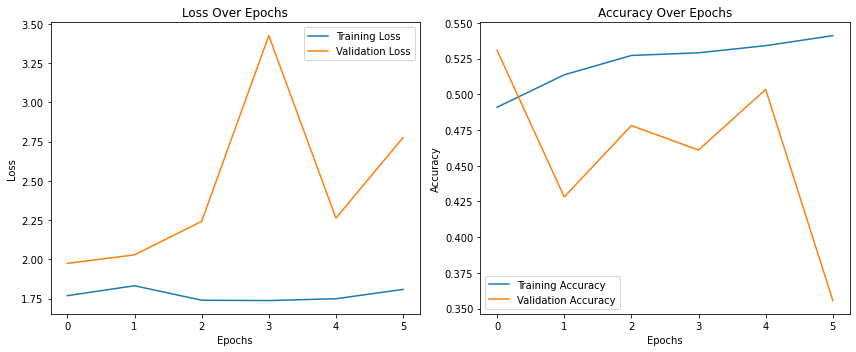

              precision    recall  f1-score   support

       anger     0.2333    0.0407    0.0693       516
     disgust     0.1622    0.0606    0.0882        99
        fear     0.0342    0.0667    0.0452        60
         joy     0.2677    0.7192    0.3901       495
     neutral     0.8594    0.2724    0.4137      1615
     sadness     0.2442    0.1597    0.1931       263
    surprise     0.2382    0.7727    0.3641       352

    accuracy                         0.3356      3400
   macro avg     0.2913    0.2989    0.2234      3400
weighted avg     0.5315    0.3356    0.3198      3400



In [21]:
model = GCNWithSkipConnections(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)
show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
show_classification_report_model(model, test_loader)



Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 223.40it/s]


Epoch 1: Train Loss = 1.7399002492102833, Val Loss = 2.0147765388212133, Train Acc = 0.5320872274143302, Val Acc = 0.5389876880984952


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 201.71it/s]


Epoch 2: Train Loss = 1.5958541965664133, Val Loss = 2.166586061235931, Train Acc = 0.5546728971962617, Val Acc = 0.48153214774281805


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 200.58it/s]


Epoch 3: Train Loss = 1.5664708248547294, Val Loss = 2.009424636816537, Train Acc = 0.5662772585669782, Val Acc = 0.4897400820793434


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 200.58it/s]


Epoch 4: Train Loss = 1.4791712549356615, Val Loss = 1.9566837457284607, Train Acc = 0.5784267912772586, Val Acc = 0.5266757865937073


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 199.65it/s]


Epoch 5: Train Loss = 1.4995935995719063, Val Loss = 2.6922358755864684, Train Acc = 0.5766355140186916, Val Acc = 0.5198358413132695


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 198.32it/s]


Epoch 6: Train Loss = 1.4527142454643143, Val Loss = 2.572025593061052, Train Acc = 0.585202492211838, Val Acc = 0.49726402188782487


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 197.97it/s]


Epoch 7: Train Loss = 1.4428247927169449, Val Loss = 2.284302534572608, Train Acc = 0.5873831775700935, Val Acc = 0.5369357045143639


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 199.04it/s]


Epoch 8: Train Loss = 1.4372945097631669, Val Loss = 2.485688644490653, Train Acc = 0.5901869158878504, Val Acc = 0.5246238030095759


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 194.25it/s]


Epoch 9: Train Loss = 1.454265712059401, Val Loss = 2.21034099359919, Train Acc = 0.5923676012461059, Val Acc = 0.5
Early stopping triggered


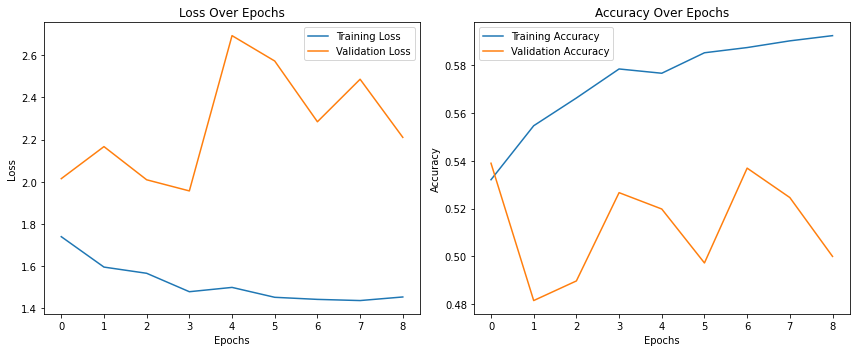

In [22]:
model = GCNWithConcatenation(num_features=768, num_classes=7)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [23]:
show_classification_report_model(model, test_loader)

              precision    recall  f1-score   support

       anger     0.5591    0.2016    0.2963       516
     disgust     0.2963    0.1616    0.2092        99
        fear     0.1212    0.1333    0.1270        60
         joy     0.3493    0.6323    0.4500       495
     neutral     0.7475    0.7022    0.7241      1615
     sadness     0.3158    0.2053    0.2488       263
    surprise     0.3902    0.5653    0.4617       352

    accuracy                         0.5376      3400
   macro avg     0.3971    0.3717    0.3596      3400
weighted avg     0.5664    0.5376    0.5298      3400



with tuning

In [24]:
best_model, best_params = tune_model(GCNWithSkipConnections, train_loader, val_loader, 768, 7)

Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 198.07it/s]


Epoch 1: Train Loss = 1.8491189054554087, Val Loss = 1.481262439523858, Train Acc = 0.48317757009345796, Val Acc = 0.5239398084815321


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.50it/s]


Epoch 2: Train Loss = 1.7294317992439137, Val Loss = 1.928763279553365, Train Acc = 0.5190809968847352, Val Acc = 0.42270861833105333


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.81it/s]


Epoch 3: Train Loss = 1.8036241447825028, Val Loss = 2.2559594190248324, Train Acc = 0.5258566978193147, Val Acc = 0.5314637482900136


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.39it/s]


Epoch 4: Train Loss = 1.836482210067369, Val Loss = 1.884961440179635, Train Acc = 0.5228193146417446, Val Acc = 0.53077975376197


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.24it/s]


Epoch 5: Train Loss = 1.7675550781662255, Val Loss = 2.280855637317506, Train Acc = 0.5400311526479751, Val Acc = 0.47332421340629277


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.33it/s]


Epoch 6: Train Loss = 1.7645138504981797, Val Loss = 2.927414943946146, Train Acc = 0.5389408099688473, Val Acc = 0.44049247606019154
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 194.83it/s]


Epoch 1: Train Loss = 112.52816695853008, Val Loss = 88.69699805575175, Train Acc = 0.4011682242990654, Val Acc = 0.3844049247606019


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.37it/s]


Epoch 2: Train Loss = 119.41873646069222, Val Loss = 106.37312161112446, Train Acc = 0.45194704049844237, Val Acc = 0.399452804377565


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.97it/s]


Epoch 3: Train Loss = 125.77903211710293, Val Loss = 130.9238592766741, Train Acc = 0.4648753894080997, Val Acc = 0.3488372093023256


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.97it/s]


Epoch 4: Train Loss = 130.10596982813902, Val Loss = 100.41522048248156, Train Acc = 0.4696261682242991, Val Acc = 0.42886456908344733


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.98it/s]


Epoch 5: Train Loss = 135.94165279524307, Val Loss = 196.68240228030416, Train Acc = 0.4771806853582555, Val Acc = 0.280437756497948


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.86it/s]


Epoch 6: Train Loss = 143.14235049502545, Val Loss = 170.49436992069488, Train Acc = 0.4767133956386293, Val Acc = 0.4911080711354309


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.86it/s]


Epoch 7: Train Loss = 142.60585003699197, Val Loss = 147.03837880607674, Train Acc = 0.49166666666666664, Val Acc = 0.42270861833105333


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.20it/s]


Epoch 8: Train Loss = 141.08134964868555, Val Loss = 142.02482223111252, Train Acc = 0.49073208722741435, Val Acc = 0.4993160054719562


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.50it/s]


Epoch 9: Train Loss = 137.55136005010962, Val Loss = 241.77725013953028, Train Acc = 0.4958722741433022, Val Acc = 0.36320109439124487


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.53it/s]


Epoch 10: Train Loss = 151.1164740157651, Val Loss = 192.15718032033354, Train Acc = 0.5014018691588785, Val Acc = 0.4015047879616963


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.30it/s]


Epoch 11: Train Loss = 144.4363117187075, Val Loss = 192.13046785887363, Train Acc = 0.504595015576324, Val Acc = 0.4425444596443228
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 194.85it/s]


Epoch 1: Train Loss = 1.7793192577117696, Val Loss = 2.2155524711193584, Train Acc = 0.48722741433021804, Val Acc = 0.5362517099863201


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.62it/s]


Epoch 2: Train Loss = 1.8099432383807985, Val Loss = 2.055260728901528, Train Acc = 0.5112928348909658, Val Acc = 0.5068399452804377


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.53it/s]


Epoch 3: Train Loss = 1.7455251256695192, Val Loss = 2.189884183066035, Train Acc = 0.5256230529595015, Val Acc = 0.48632010943912446


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.25it/s]


Epoch 4: Train Loss = 1.7509198170708933, Val Loss = 2.6246941616944106, Train Acc = 0.5342679127725857, Val Acc = 0.46511627906976744


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.97it/s]


Epoch 5: Train Loss = 1.741875638023002, Val Loss = 2.0910705746186, Train Acc = 0.5346573208722741, Val Acc = 0.40287277701778385


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.25it/s]


Epoch 6: Train Loss = 1.8591511644555188, Val Loss = 2.4095483163319944, Train Acc = 0.5353582554517134, Val Acc = 0.47332421340629277


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.48it/s]


Epoch 7: Train Loss = 1.8061619859695148, Val Loss = 2.1191959132819815, Train Acc = 0.5401869158878505, Val Acc = 0.5013679890560876


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.32it/s]


Epoch 8: Train Loss = 1.7724955956288635, Val Loss = 2.257728313369228, Train Acc = 0.5428348909657321, Val Acc = 0.53077975376197


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.23it/s]


Epoch 9: Train Loss = 1.6876606523647044, Val Loss = 2.6817566277903366, Train Acc = 0.5500778816199376, Val Acc = 0.45896032831737343


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.97it/s]


Epoch 10: Train Loss = 1.843225780599323, Val Loss = 3.0105829893656644, Train Acc = 0.5436915887850468, Val Acc = 0.5102599179206566


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.23it/s]


Epoch 11: Train Loss = 1.7094173085957496, Val Loss = 3.5454111955818477, Train Acc = 0.5596573208722742, Val Acc = 0.3399452804377565


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 178.31it/s]


Epoch 12: Train Loss = 1.8091308495306024, Val Loss = 2.2301414166753806, Train Acc = 0.5533489096573209, Val Acc = 0.4781121751025992
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.64it/s]


Epoch 1: Train Loss = 106.51776413321848, Val Loss = 204.5557323982396, Train Acc = 0.40763239875389407, Val Acc = 0.43912448700410395


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.57it/s]


Epoch 2: Train Loss = 124.49868053758897, Val Loss = 125.63518660818609, Train Acc = 0.4589563862928349, Val Acc = 0.472640218878249


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 174.87it/s]


Epoch 3: Train Loss = 126.0991960282216, Val Loss = 486.9838305720576, Train Acc = 0.45848909657320874, Val Acc = 0.1518467852257182


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.69it/s]


Epoch 4: Train Loss = 139.5657099402888, Val Loss = 120.6411017621005, Train Acc = 0.4716510903426791, Val Acc = 0.4240766073871409


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 175.35it/s]


Epoch 5: Train Loss = 132.1238104199292, Val Loss = 138.02554129936308, Train Acc = 0.4780373831775701, Val Acc = 0.4719562243502052


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.29it/s]


Epoch 6: Train Loss = 132.0334183077542, Val Loss = 145.56880646682106, Train Acc = 0.48419003115264797, Val Acc = 0.472640218878249


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 176.16it/s]


Epoch 7: Train Loss = 140.98498218046913, Val Loss = 143.6118576051197, Train Acc = 0.48753894080996885, Val Acc = 0.4883720930232558


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 170.86it/s]


Epoch 8: Train Loss = 139.2455953601114, Val Loss = 192.69817951321602, Train Acc = 0.4913551401869159, Val Acc = 0.32147742818057456


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 167.67it/s]


Epoch 9: Train Loss = 147.480144416637, Val Loss = 147.89335148491793, Train Acc = 0.4928348909657321, Val Acc = 0.5294117647058824


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.52it/s]


Epoch 10: Train Loss = 136.13626533442007, Val Loss = 137.33920956225964, Train Acc = 0.4927570093457944, Val Acc = 0.4151846785225718


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 187.29it/s]


Epoch 11: Train Loss = 154.06151856882659, Val Loss = 224.99186337122632, Train Acc = 0.49540498442367603, Val Acc = 0.35567715458276333


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.89it/s]


Epoch 12: Train Loss = 141.65131536052908, Val Loss = 145.2680481007816, Train Acc = 0.5060747663551401, Val Acc = 0.4528043775649795


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.97it/s]


Epoch 13: Train Loss = 146.64211146983575, Val Loss = 229.99723034986704, Train Acc = 0.5035046728971962, Val Acc = 0.38303693570451436


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.94it/s]


Epoch 14: Train Loss = 154.83659998087154, Val Loss = 165.86177815577636, Train Acc = 0.5050623052959502, Val Acc = 0.46580027359781123
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 225.74it/s]


Epoch 1: Train Loss = 1.2012526030221058, Val Loss = 1.2785564390045625, Train Acc = 0.5850467289719626, Val Acc = 0.5683994528043775


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 201.53it/s]


Epoch 2: Train Loss = 1.0944526543047417, Val Loss = 1.2747627883321708, Train Acc = 0.6140186915887851, Val Acc = 0.5745554035567716


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 195.93it/s]


Epoch 3: Train Loss = 1.0547734180016926, Val Loss = 1.3301511333220535, Train Acc = 0.6221183800623052, Val Acc = 0.5642954856361149


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 198.57it/s]


Epoch 4: Train Loss = 1.0361552322740426, Val Loss = 1.3406217326306635, Train Acc = 0.6245327102803738, Val Acc = 0.5540355677154583


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 197.65it/s]


Epoch 5: Train Loss = 1.0125463912312018, Val Loss = 1.3329562323857789, Train Acc = 0.6327102803738318, Val Acc = 0.554719562243502


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 196.21it/s]


Epoch 6: Train Loss = 0.9899760800974845, Val Loss = 1.3414636551954404, Train Acc = 0.6358255451713396, Val Acc = 0.579343365253078


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 197.84it/s]


Epoch 7: Train Loss = 0.9714289810063309, Val Loss = 1.3698601711127494, Train Acc = 0.6373052959501557, Val Acc = 0.5465116279069767


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 196.93it/s]


Epoch 8: Train Loss = 0.9565578892927394, Val Loss = 1.365615075233358, Train Acc = 0.6419003115264797, Val Acc = 0.5697674418604651


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 164.08it/s]


Epoch 9: Train Loss = 0.9362837723259064, Val Loss = 1.3823271694696613, Train Acc = 0.6483644859813084, Val Acc = 0.5465116279069767


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:13<00:00, 164.96it/s]


Epoch 10: Train Loss = 0.922353837272946, Val Loss = 1.3701110306920277, Train Acc = 0.6514797507788161, Val Acc = 0.5656634746922025


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 171.62it/s]


Epoch 11: Train Loss = 0.9112116684964239, Val Loss = 1.3846107449520517, Train Acc = 0.6513239875389408, Val Acc = 0.5526675786593708


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:14<00:00, 151.77it/s]


Epoch 12: Train Loss = 0.9013215551867646, Val Loss = 1.3671683868600262, Train Acc = 0.6519470404984423, Val Acc = 0.5478796169630643
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.579343365253078


TypeError: show_classification_report_model() takes 2 positional arguments but 3 were given

In [27]:
show_classification_report_model(best_model, test_loader)

              precision    recall  f1-score   support

       anger     0.5411    0.3702    0.4396       516
     disgust     0.1894    0.2525    0.2165        99
        fear     0.2373    0.2333    0.2353        60
         joy     0.5253    0.3980    0.4529       495
     neutral     0.7238    0.8000    0.7600      1615
     sadness     0.3525    0.1863    0.2438       263
    surprise     0.3968    0.6278    0.4862       352

    accuracy                         0.5850      3400
   macro avg     0.4237    0.4097    0.4049      3400
weighted avg     0.5805    0.5850    0.5733      3400



In [28]:
best_model, best_params = tune_model(GCNWithConcatenation, train_loader, val_loader, 768, 7)

show_classification_report_model(best_model, test_loader)

Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 233.91it/s]


Epoch 1: Train Loss = 1.192624999915629, Val Loss = 1.3079843520014374, Train Acc = 0.5892523364485981, Val Acc = 0.5677154582763337


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 210.67it/s]


Epoch 2: Train Loss = 1.0779148016349172, Val Loss = 1.311353415278373, Train Acc = 0.6221183800623052, Val Acc = 0.5595075239398085


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 167.84it/s]


Epoch 3: Train Loss = 1.0426985872978414, Val Loss = 1.2846630229718154, Train Acc = 0.6302959501557632, Val Acc = 0.5711354309165527


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 194.57it/s]


Epoch 4: Train Loss = 1.012786264142401, Val Loss = 1.3304573703143332, Train Acc = 0.6313084112149533, Val Acc = 0.5554035567715458


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 197.52it/s]


Epoch 5: Train Loss = 0.9948511019211125, Val Loss = 1.3108556431476717, Train Acc = 0.6374610591900312, Val Acc = 0.5718194254445964


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 200.17it/s]


Epoch 6: Train Loss = 0.9757340004383069, Val Loss = 1.3239106679611183, Train Acc = 0.6393302180685358, Val Acc = 0.56703146374829


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 193.66it/s]


Epoch 7: Train Loss = 0.959666952039805, Val Loss = 1.3234756732842436, Train Acc = 0.6437694704049844, Val Acc = 0.5560875512995896


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 185.73it/s]


Epoch 8: Train Loss = 0.946918900148874, Val Loss = 1.3468036338617957, Train Acc = 0.6450155763239875, Val Acc = 0.5718194254445964
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:09<00:00, 224.09it/s]


Epoch 1: Train Loss = 1.7409284102664093, Val Loss = 2.5815569556559677, Train Acc = 0.526791277258567, Val Acc = 0.35772913816689467


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 196.38it/s]


Epoch 2: Train Loss = 1.627041160005498, Val Loss = 2.165387834316223, Train Acc = 0.555841121495327, Val Acc = 0.5444596443228454


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.25it/s]


Epoch 3: Train Loss = 1.549458713476512, Val Loss = 2.2679795306995167, Train Acc = 0.5698598130841122, Val Acc = 0.4945280437756498


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.91it/s]


Epoch 4: Train Loss = 1.515338477054158, Val Loss = 3.0862918810806823, Train Acc = 0.5757009345794393, Val Acc = 0.47537619699042405


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 181.68it/s]


Epoch 5: Train Loss = 1.5185764125928134, Val Loss = 2.0754260400575326, Train Acc = 0.5776479750778816, Val Acc = 0.521203830369357


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 191.08it/s]


Epoch 6: Train Loss = 1.4356153604877548, Val Loss = 2.291460674400258, Train Acc = 0.5883956386292835, Val Acc = 0.5321477428180574


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.39it/s]


Epoch 7: Train Loss = 1.5305124923421327, Val Loss = 2.334295577405094, Train Acc = 0.5756230529595016, Val Acc = 0.521203830369357


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.44it/s]


Epoch 8: Train Loss = 1.391751786497857, Val Loss = 2.7314347642271226, Train Acc = 0.5911214953271028, Val Acc = 0.37209302325581395


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.77it/s]


Epoch 9: Train Loss = 1.4378431461314163, Val Loss = 2.257910391755609, Train Acc = 0.5871495327102804, Val Acc = 0.5054719562243503


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 191.01it/s]


Epoch 10: Train Loss = 1.4011842046130183, Val Loss = 2.372448897212356, Train Acc = 0.6024143302180686, Val Acc = 0.5170998632010944
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 213.35it/s]


Epoch 1: Train Loss = 1.7431248540261381, Val Loss = 1.8269959197664218, Train Acc = 0.5263239875389408, Val Acc = 0.5362517099863201


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 114.86it/s]


Epoch 2: Train Loss = 1.5900296395346771, Val Loss = 2.109333358406676, Train Acc = 0.5552180685358256, Val Acc = 0.5027359781121751


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 177.75it/s]


Epoch 3: Train Loss = 1.5559198469538724, Val Loss = 2.176798216074153, Train Acc = 0.5624610591900312, Val Acc = 0.4904240766073871


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 180.91it/s]


Epoch 4: Train Loss = 1.4905314145034465, Val Loss = 3.003143438177735, Train Acc = 0.5751557632398754, Val Acc = 0.4945280437756498


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.82it/s]


Epoch 5: Train Loss = 1.4798142456692909, Val Loss = 3.3630469764134396, Train Acc = 0.5807632398753894, Val Acc = 0.33105335157318744


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.43it/s]


Epoch 6: Train Loss = 1.4497340057976813, Val Loss = 2.4109877087382805, Train Acc = 0.5863707165109034, Val Acc = 0.4411764705882353
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 215.62it/s]


Epoch 1: Train Loss = 1.1948964203638888, Val Loss = 1.2634935363299318, Train Acc = 0.5838006230529595, Val Acc = 0.5629274965800274


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 195.58it/s]


Epoch 2: Train Loss = 1.0792815692257136, Val Loss = 1.299552582576871, Train Acc = 0.6201713395638629, Val Acc = 0.560875512995896


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.07it/s]


Epoch 3: Train Loss = 1.0385468515584728, Val Loss = 1.2986090097714353, Train Acc = 0.6244548286604361, Val Acc = 0.5567715458276333


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 184.85it/s]


Epoch 4: Train Loss = 1.012253063164341, Val Loss = 1.2846959905215987, Train Acc = 0.6297507788161993, Val Acc = 0.5738714090287278


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.96it/s]


Epoch 5: Train Loss = 0.9947444770075553, Val Loss = 1.3279176577787708, Train Acc = 0.6376947040498442, Val Acc = 0.573187414500684


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 192.48it/s]


Epoch 6: Train Loss = 0.9723338045585141, Val Loss = 1.2898399895264043, Train Acc = 0.641588785046729, Val Acc = 0.5759233926128591
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:10<00:00, 207.32it/s]


Epoch 1: Train Loss = 1.7416753634765985, Val Loss = 2.3352881824498546, Train Acc = 0.5237538940809969, Val Acc = 0.5369357045143639


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 186.69it/s]


Epoch 2: Train Loss = 1.6339565751639653, Val Loss = 2.2824089726933314, Train Acc = 0.554595015576324, Val Acc = 0.5006839945280438


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 190.55it/s]


Epoch 3: Train Loss = 1.5151035853664965, Val Loss = 2.3083387885225455, Train Acc = 0.5687694704049844, Val Acc = 0.5041039671682627


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.69it/s]


Epoch 4: Train Loss = 1.5199528269675755, Val Loss = 2.038478024542349, Train Acc = 0.5786604361370716, Val Acc = 0.5253077975376197


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.44it/s]


Epoch 5: Train Loss = 1.5018517405296195, Val Loss = 2.1990813542191905, Train Acc = 0.5723520249221183, Val Acc = 0.5075239398084815


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 189.71it/s]


Epoch 6: Train Loss = 1.4655595471641627, Val Loss = 2.2854141705740068, Train Acc = 0.5843457943925233, Val Acc = 0.5328317373461012


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:12<00:00, 179.38it/s]


Epoch 7: Train Loss = 1.4159345695797971, Val Loss = 2.3032916910929124, Train Acc = 0.5883956386292835, Val Acc = 0.4740082079343365


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 188.56it/s]


Epoch 8: Train Loss = 1.4451669253024697, Val Loss = 2.533308522834408, Train Acc = 0.5910436137071651, Val Acc = 0.5013679890560876


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:11<00:00, 191.67it/s]


Epoch 9: Train Loss = 1.3793585503106711, Val Loss = 2.605410187025727, Train Acc = 0.6005451713395639, Val Acc = 0.44459644322845415
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5759233926128591
              precision    recall  f1-score   support

       anger     0.5638    0.3256    0.4128       516
     disgust     0.5200    0.1313    0.2097        99
        fear     0.2308    0.1000    0.1395        60
         joy     0.5062    0.4929    0.4995       495
     neutral     0.6894    0.8879    0.7762      1615
     sadness     0.4706    0.1521    0.2299       263
    surprise     0.4629    0.5312    0.4947       352

    accuracy                         0.6153      3400
   macro avg     0.4919    0.3744    0.3946      3400
weighted avg     0.5903    0.6153    0.5816      3400



In [29]:
# model = GCNWithSkipConnections(num_features=768, num_classes=7)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()

# train_losses = []
# val_losses = []
# train_accuracies = []
# val_accuracies = []
# early_stop_threshold = 0.0001
# best_val_loss = float('inf')
# no_improve_epochs = 0
# max_no_improve_epochs = 5

# for epoch in range(25):
#     model.train()
#     train_loss = 0
#     correct_train = 0
#     total_train = 0
    
#     for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
#         optimizer.zero_grad()
#         out = model(data.x, data.edge_index)
#         loss = criterion(out, data.y)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
        
#         preds = out.argmax(dim=1)
#         correct_train += (preds == data.y).sum().item()
#         total_train += data.y.size(0)
    
#     train_losses.append(train_loss / len(train_loader))
#     train_accuracies.append(correct_train / total_train)
    
#     model.eval()
#     val_loss = 0
#     correct_val = 0
#     total_val = 0
    
#     with torch.no_grad():
#         for data in val_loader:
#             out = model(data.x, data.edge_index)
#             loss = criterion(out, data.y)
#             val_loss += loss.item()
            
#             preds = out.argmax(dim=1)
#             correct_val += (preds == data.y).sum().item()
#             total_val += data.y.size(0)
    
#     val_losses.append(val_loss / len(val_loader))
#     val_accuracies.append(correct_val / total_val)
    
#     print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")
    
#     if best_val_loss - val_losses[-1] < early_stop_threshold:
#         no_improve_epochs += 1
#         if no_improve_epochs >= max_no_improve_epochs:
#             print("Early stopping triggered")
#             break
#     else:
#         no_improve_epochs = 0
#         best_val_loss = val_losses[-1]

In [30]:
# # Plot learning curves
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.title('Loss Over Epochs')

# plt.subplot(1, 2, 2)
# plt.plot(train_accuracies, label='Training Accuracy')
# plt.plot(val_accuracies, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.title('Accuracy Over Epochs')

# plt.tight_layout()
# plt.show()

In [31]:
# # Classification report on test set
# model.eval()
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for data in test_loader:
#         out = model(data.x, data.edge_index)
#         preds = out.argmax(dim=1)
#         all_preds.extend(preds.cpu().numpy())
#         all_labels.extend(data.y.cpu().numpy())

# print(classification_report(all_labels, all_preds, target_names=label_decoder.values()))

#### RGCN

In [39]:
def train_relational_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            out = model(data.x, data.edge_index , data.edge_type)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                out = model(data.x, data.edge_index, data.edge_type)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_relation_model(model_class, train_loader, val_loader, num_features, num_classes, num_relations):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes, num_relations)
        model, _, _, _, val_accuracies = train_relational_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_classification_report_relation_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            out = model(data.x, data.edge_index, data.edge_type)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values(),digits = 4))

Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 117.87it/s]


Epoch 1: Train Loss = 1.7937319594439705, Val Loss = 1.6073111317913842, Train Acc = 0.49330218068535825, Val Acc = 0.472640218878249


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 98.08it/s]


Epoch 2: Train Loss = 1.8068233753793652, Val Loss = 1.9741974451372193, Train Acc = 0.5149532710280373, Val Acc = 0.4774281805745554


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 91.44it/s]


Epoch 3: Train Loss = 1.7561534588637961, Val Loss = 3.3061553757499764, Train Acc = 0.5320872274143302, Val Acc = 0.28796169630642954


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.87it/s]


Epoch 4: Train Loss = 1.7184514687869792, Val Loss = 1.9742072863745745, Train Acc = 0.5361370716510904, Val Acc = 0.5109439124487004


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.58it/s]


Epoch 5: Train Loss = 1.8120524339127198, Val Loss = 2.305163621571329, Train Acc = 0.5343457943925234, Val Acc = 0.3440492476060191


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.09it/s]


Epoch 6: Train Loss = 1.7772083439940245, Val Loss = 2.6092513219086904, Train Acc = 0.5349688473520249, Val Acc = 0.5198358413132695
Early stopping triggered


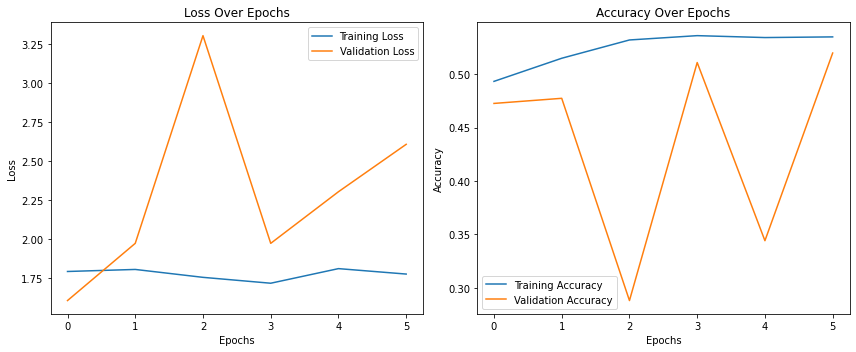

              precision    recall  f1-score   support

       anger     0.4811    0.1977    0.2802       516
     disgust     0.6667    0.0202    0.0392        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.3649    0.7152    0.4833       495
     neutral     0.6655    0.8204    0.7349      1615
     sadness     0.5714    0.0152    0.0296       263
    surprise     0.6019    0.3608    0.4512       352

    accuracy                         0.5629      3400
   macro avg     0.4788    0.3042    0.2883      3400
weighted avg     0.5682    0.5629    0.5121      3400



In [40]:
model = RGCNWithGAT(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

In [41]:
best_model, best_params = tune_relation_model(RGCNWithGAT, train_loader, val_loader, 768, 7, 3)

show_classification_report_relation_model(best_model, test_loader)

Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 111.03it/s]


Epoch 1: Train Loss = 1.8042527966339819, Val Loss = 2.182403176450343, Train Acc = 0.49073208722741435, Val Acc = 0.42476060191518467


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.14it/s]


Epoch 2: Train Loss = 1.7206806314237635, Val Loss = 2.021450348722714, Train Acc = 0.52398753894081, Val Acc = 0.4186046511627907


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.13it/s]


Epoch 3: Train Loss = 1.7201501087862805, Val Loss = 1.886243765551114, Train Acc = 0.528582554517134, Val Acc = 0.5


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 100.21it/s]


Epoch 4: Train Loss = 1.7911005113244014, Val Loss = 1.8664043165398416, Train Acc = 0.532398753894081, Val Acc = 0.506155950752394


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.14it/s]


Epoch 5: Train Loss = 1.8142680440684469, Val Loss = 1.78481019343879, Train Acc = 0.535202492211838, Val Acc = 0.4849521203830369


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.91it/s]


Epoch 6: Train Loss = 1.7304488348420919, Val Loss = 2.4736323783657066, Train Acc = 0.5437694704049845, Val Acc = 0.40287277701778385


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.31it/s]


Epoch 7: Train Loss = 1.8355634344148173, Val Loss = 2.467762338946125, Train Acc = 0.5415109034267913, Val Acc = 0.49589603283173733


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.46it/s]


Epoch 8: Train Loss = 1.8722160629680022, Val Loss = 2.0869893141366815, Train Acc = 0.5369158878504673, Val Acc = 0.42544459644322846


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.98it/s]


Epoch 9: Train Loss = 1.6803611881178733, Val Loss = 2.0811911465910575, Train Acc = 0.5530373831775701, Val Acc = 0.5355677154582763


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.42it/s]


Epoch 10: Train Loss = 1.7930916859848771, Val Loss = 2.274193976988533, Train Acc = 0.5407320872274143, Val Acc = 0.5054719562243503


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.69it/s]


Epoch 11: Train Loss = 1.737414952846868, Val Loss = 3.32080522654923, Train Acc = 0.5566199376947041, Val Acc = 0.353625170998632


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.21it/s]


Epoch 12: Train Loss = 1.7647690595339252, Val Loss = 3.2113826779864247, Train Acc = 0.5568535825545171, Val Acc = 0.4582763337893297


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.29it/s]


Epoch 13: Train Loss = 1.748793149733617, Val Loss = 2.7853075042358357, Train Acc = 0.5587227414330218, Val Acc = 0.4911080711354309


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 91.76it/s]


Epoch 14: Train Loss = 1.7410151400070213, Val Loss = 2.4062517434929895, Train Acc = 0.5509345794392523, Val Acc = 0.5136798905608755


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.63it/s]


Epoch 15: Train Loss = 1.7583326167351785, Val Loss = 2.722813606723725, Train Acc = 0.5580218068535826, Val Acc = 0.5054719562243503
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 109.15it/s]


Epoch 1: Train Loss = 1.7999022058206686, Val Loss = 1.7726665653702285, Train Acc = 0.4921339563862928, Val Acc = 0.46169630642954856


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.85it/s]


Epoch 2: Train Loss = 1.7898305890522386, Val Loss = 2.56892966164483, Train Acc = 0.5188473520249222, Val Acc = 0.3816689466484268


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.99it/s]


Epoch 3: Train Loss = 1.7279413534785648, Val Loss = 1.9399627885945072, Train Acc = 0.5313862928348909, Val Acc = 0.45896032831737343


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.17it/s]


Epoch 4: Train Loss = 1.8137116804244553, Val Loss = 1.875669473847288, Train Acc = 0.533411214953271, Val Acc = 0.5512995896032832


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.89it/s]


Epoch 5: Train Loss = 1.836020970582245, Val Loss = 2.117376040474132, Train Acc = 0.5320872274143302, Val Acc = 0.4186046511627907


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.10it/s]


Epoch 6: Train Loss = 1.7529597535737593, Val Loss = 2.295138011424354, Train Acc = 0.536993769470405, Val Acc = 0.5164158686730507
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 109.53it/s]


Epoch 1: Train Loss = 1.7749453067855265, Val Loss = 1.6597856205508665, Train Acc = 0.49252336448598133, Val Acc = 0.4883720930232558


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 96.55it/s]


Epoch 2: Train Loss = 1.7140625170104344, Val Loss = 2.5726157316179186, Train Acc = 0.516822429906542, Val Acc = 0.4213406292749658


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.77it/s]


Epoch 3: Train Loss = 1.7465168561643318, Val Loss = 1.829524702922855, Train Acc = 0.5304517133956387, Val Acc = 0.47127222982216144


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.12it/s]


Epoch 4: Train Loss = 1.8107476038643233, Val Loss = 1.675613511160568, Train Acc = 0.5341121495327102, Val Acc = 0.5020519835841313


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.10it/s]


Epoch 5: Train Loss = 1.7210234353887413, Val Loss = 2.0477242306088255, Train Acc = 0.5432242990654206, Val Acc = 0.506155950752394


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.69it/s]


Epoch 6: Train Loss = 1.7523887675651495, Val Loss = 1.9461423837066698, Train Acc = 0.5471183800623053, Val Acc = 0.5


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.24it/s]


Epoch 7: Train Loss = 1.7704599290835041, Val Loss = 2.158379777326007, Train Acc = 0.5412772585669782, Val Acc = 0.48768809849521205


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.58it/s]


Epoch 8: Train Loss = 1.7559609991917484, Val Loss = 2.023972873642385, Train Acc = 0.5406542056074767, Val Acc = 0.5129958960328317


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.89it/s]


Epoch 9: Train Loss = 1.773112938526034, Val Loss = 2.1092313315544744, Train Acc = 0.5448598130841121, Val Acc = 0.4897400820793434


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.10it/s]


Epoch 10: Train Loss = 1.6480765646862352, Val Loss = 2.5884450911958186, Train Acc = 0.5538940809968848, Val Acc = 0.4124487004103967


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.81it/s]


Epoch 11: Train Loss = 1.808818059547387, Val Loss = 2.514198248057316, Train Acc = 0.5468847352024923, Val Acc = 0.5047879616963065
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 114.61it/s]


Epoch 1: Train Loss = 1.2047125991675314, Val Loss = 1.292620722176852, Train Acc = 0.586214953271028, Val Acc = 0.5595075239398085


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.37it/s]


Epoch 2: Train Loss = 1.0958622195007695, Val Loss = 1.2791890150418987, Train Acc = 0.6123052959501558, Val Acc = 0.5704514363885089


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 99.52it/s]


Epoch 3: Train Loss = 1.0545206470699566, Val Loss = 1.3070767562974381, Train Acc = 0.6240654205607477, Val Acc = 0.56703146374829


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.13it/s]


Epoch 4: Train Loss = 1.0262147220041327, Val Loss = 1.266906177914805, Train Acc = 0.6271806853582554, Val Acc = 0.5759233926128591


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.13it/s]


Epoch 5: Train Loss = 1.003997562402273, Val Loss = 1.309855856622259, Train Acc = 0.6338785046728972, Val Acc = 0.5704514363885089


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:21<00:00, 98.76it/s]


Epoch 6: Train Loss = 0.9750220361683642, Val Loss = 1.4103827728269, Train Acc = 0.6381619937694704, Val Acc = 0.5690834473324213


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.28it/s]


Epoch 7: Train Loss = 0.9618840933316042, Val Loss = 1.3785642933928304, Train Acc = 0.634968847352025, Val Acc = 0.5383036935704515


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.72it/s]


Epoch 8: Train Loss = 0.945665898958773, Val Loss = 1.3681280835359184, Train Acc = 0.6440031152647975, Val Acc = 0.5581395348837209


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.33it/s]


Epoch 9: Train Loss = 0.924933300110947, Val Loss = 1.3666055396199226, Train Acc = 0.6479750778816199, Val Acc = 0.5882352941176471
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:20<00:00, 106.27it/s]


Epoch 1: Train Loss = 1.7952138837557867, Val Loss = 1.8745500088289933, Train Acc = 0.4927570093457944, Val Acc = 0.4856361149110807


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.30it/s]


Epoch 2: Train Loss = 1.7292272846585277, Val Loss = 2.6496584659028386, Train Acc = 0.5215732087227415, Val Acc = 0.426812585499316


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.00it/s]


Epoch 3: Train Loss = 1.7848850678936894, Val Loss = 2.224875293465124, Train Acc = 0.5315420560747663, Val Acc = 0.40834473324213405


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.37it/s]


Epoch 4: Train Loss = 1.7195581561778521, Val Loss = 1.907902559046461, Train Acc = 0.5310747663551402, Val Acc = 0.493844049247606


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.89it/s]


Epoch 5: Train Loss = 1.836946574715063, Val Loss = 2.2949032458105916, Train Acc = 0.5302180685358255, Val Acc = 0.4801641586867305


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.90it/s]


Epoch 6: Train Loss = 1.7839862422717148, Val Loss = 1.9625624919241225, Train Acc = 0.5366043613707165, Val Acc = 0.5239398084815321


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.48it/s]


Epoch 7: Train Loss = 1.8038490901742112, Val Loss = 2.1656001404037077, Train Acc = 0.5431464174454829, Val Acc = 0.5136798905608755


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.10it/s]


Epoch 8: Train Loss = 1.7746720145684405, Val Loss = 2.215417195311575, Train Acc = 0.5443146417445482, Val Acc = 0.41997264021887826


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.20it/s]


Epoch 9: Train Loss = 2.3398212988135163, Val Loss = 2.6263045747402227, Train Acc = 0.535436137071651, Val Acc = 0.43433652530779754


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.17it/s]


Epoch 10: Train Loss = 1.6048025278100728, Val Loss = 2.389843210224407, Train Acc = 0.5532710280373832, Val Acc = 0.5266757865937073


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.89it/s]


Epoch 11: Train Loss = 1.8112355968607248, Val Loss = 2.3730205503025057, Train Acc = 0.5434579439252336, Val Acc = 0.5143638850889193
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5882352941176471
              precision    recall  f1-score   support

       anger     0.5134    0.3721    0.4315       516
     disgust     1.0000    0.0303    0.0588        99
        fear     0.5000    0.2167    0.3023        60
         joy     0.5058    0.5253    0.5154       495
     neutral     0.6775    0.9053    0.7750      1615
     sadness     0.4694    0.0875    0.1474       263
    surprise     0.5290    0.4148    0.4650       352

    accuracy                         0.6174      3400
   macro avg     0.5993    0.3645    0.3851      3400
weighted avg     0.6024    0.6174    0.5752      3400



#### RGAT

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:52<00:00, 12.52it/s]


Epoch 1: Train Loss = 604.2062553142569, Val Loss = 338.9592972843735, Train Acc = 0.2823208722741433, Val Acc = 0.40013679890560877


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:50<00:00, 12.66it/s]


Epoch 2: Train Loss = 456.2784681857032, Val Loss = 277.95391430865834, Train Acc = 0.30233644859813086, Val Acc = 0.35294117647058826


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:50<00:00, 12.67it/s]


Epoch 3: Train Loss = 447.3521554087204, Val Loss = 514.1308558004873, Train Acc = 0.32032710280373833, Val Acc = 0.280437756497948


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:52<00:00, 12.54it/s]


Epoch 4: Train Loss = 305.19655424467663, Val Loss = 76.25582645291115, Train Acc = 0.35210280373831776, Val Acc = 0.46511627906976744


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:55<00:00, 12.33it/s]


Epoch 5: Train Loss = 412.63835863585035, Val Loss = 111.65245054538035, Train Acc = 0.34649532710280373, Val Acc = 0.35567715458276333


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:55<00:00, 12.31it/s]


Epoch 6: Train Loss = 362.20365746156074, Val Loss = 324.7660743224469, Train Acc = 0.3590342679127726, Val Acc = 0.46169630642954856


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:52<00:00, 12.51it/s]


Epoch 7: Train Loss = 408.9355918701642, Val Loss = 337.524526837009, Train Acc = 0.3780373831775701, Val Acc = 0.35704514363885087


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:54<00:00, 12.38it/s]


Epoch 8: Train Loss = 724.9333112215493, Val Loss = 286.7816521100792, Train Acc = 0.35630841121495327, Val Acc = 0.4548563611491108


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [02:51<00:00, 12.59it/s]


Epoch 9: Train Loss = 349.1831247974549, Val Loss = 178.6735132333029, Train Acc = 0.39080996884735203, Val Acc = 0.4794801641586867
Early stopping triggered


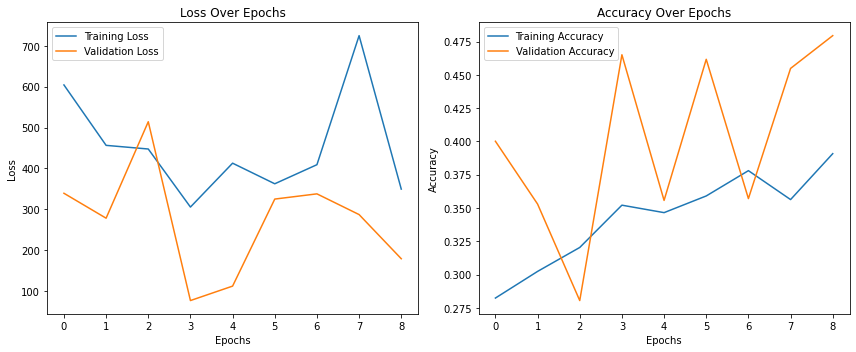

              precision    recall  f1-score   support

       anger     0.3988    0.1298    0.1959       516
     disgust     0.0909    0.0101    0.0182        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.4104    0.2869    0.3377       495
     neutral     0.5817    0.9276    0.7150      1615
     sadness     0.2500    0.0228    0.0418       263
    surprise     0.3536    0.2642    0.3024       352

    accuracy                         0.5315      3400
   macro avg     0.2979    0.2345    0.2302      3400
weighted avg     0.4552    0.5315    0.4536      3400



In [43]:
model = RGATWithSkipConnections(num_features=768, num_classes=7, num_relations=3)

model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_relational_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_relation_model(model, test_loader)

In [44]:
best_model, best_params = tune_relation_model(RGATWithSkipConnections, train_loader, val_loader, 768, 7, 3)

show_classification_report_relation_model(best_model, test_loader)

Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.18it/s]


Epoch 1: Train Loss = 604.3686178198396, Val Loss = 464.57289813006366, Train Acc = 0.21799065420560748, Val Acc = 0.12859097127222982


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.92it/s]


Epoch 2: Train Loss = 862.4274270152604, Val Loss = 425.18264677259657, Train Acc = 0.24322429906542056, Val Acc = 0.40013679890560877


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 120.42it/s]


Epoch 3: Train Loss = 474.0626381835437, Val Loss = 269.70022499936596, Train Acc = 0.2657320872274143, Val Acc = 0.3850889192886457


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 118.66it/s]


Epoch 4: Train Loss = 546.3244184818138, Val Loss = 367.8412444353103, Train Acc = 0.26347352024922116, Val Acc = 0.17305061559507523


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 109.81it/s]


Epoch 5: Train Loss = 548.9677497620266, Val Loss = 144.74372197708897, Train Acc = 0.27320872274143304, Val Acc = 0.3228454172366621


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:19<00:00, 112.97it/s]


Epoch 6: Train Loss = 231.19219945627728, Val Loss = 83.54666346678579, Train Acc = 0.31799065420560746, Val Acc = 0.4110807113543092


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.83it/s]


Epoch 7: Train Loss = 603.058599210786, Val Loss = 302.6576263256646, Train Acc = 0.26690031152647975, Val Acc = 0.21682626538987687


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.08it/s]


Epoch 8: Train Loss = 424.5243286893336, Val Loss = 152.34387667239815, Train Acc = 0.2969626168224299, Val Acc = 0.3112175102599179


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.53it/s]


Epoch 9: Train Loss = 421.5230817693815, Val Loss = 148.22903046570994, Train Acc = 0.2728193146417445, Val Acc = 0.32694938440492477


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 122.01it/s]


Epoch 10: Train Loss = 218.1661850426308, Val Loss = 126.51095108746172, Train Acc = 0.3161214953271028, Val Acc = 0.4220246238030096


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 123.99it/s]


Epoch 11: Train Loss = 842.6548485282835, Val Loss = 390.22111377892674, Train Acc = 0.27110591900311526, Val Acc = 0.399452804377565
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.67it/s]


Epoch 1: Train Loss = 447.84634408174054, Val Loss = 244.33065868707942, Train Acc = 0.22422118380062306, Val Acc = 0.20383036935704515


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.97it/s]


Epoch 2: Train Loss = 292.1155013423064, Val Loss = 263.0995337168376, Train Acc = 0.2767133956386293, Val Acc = 0.19630642954856362


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.36it/s]


Epoch 3: Train Loss = 325.8801662491659, Val Loss = 276.25562070210776, Train Acc = 0.2883177570093458, Val Acc = 0.22845417236662108


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.14it/s]


Epoch 4: Train Loss = 268.5256986672648, Val Loss = 294.44101976968886, Train Acc = 0.2926791277258567, Val Acc = 0.22571819425444598


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.28it/s]


Epoch 5: Train Loss = 607.6777872854834, Val Loss = 156.7301107040158, Train Acc = 0.252803738317757, Val Acc = 0.4110807113543092


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 121.57it/s]


Epoch 6: Train Loss = 949.988398317803, Val Loss = 863.6401966377541, Train Acc = 0.2541277258566978, Val Acc = 0.2503419972640219


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 131.02it/s]


Epoch 7: Train Loss = 1070.336106207816, Val Loss = 250.63180717803814, Train Acc = 0.2565420560747664, Val Acc = 0.3679890560875513


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.53it/s]


Epoch 8: Train Loss = 683.3063489243366, Val Loss = 201.57577832010057, Train Acc = 0.2707943925233645, Val Acc = 0.4151846785225718


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 127.15it/s]


Epoch 9: Train Loss = 922.1670551522002, Val Loss = 193.26281506087375, Train Acc = 0.277803738317757, Val Acc = 0.4069767441860465


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 127.78it/s]


Epoch 10: Train Loss = 450.2236776797495, Val Loss = 157.29200968785898, Train Acc = 0.3115264797507788, Val Acc = 0.38645690834473323


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.49it/s]


Epoch 11: Train Loss = 823.7171460213067, Val Loss = 485.6572282155355, Train Acc = 0.2762461059190031, Val Acc = 0.3898768809849521


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.67it/s]


Epoch 12: Train Loss = 754.5234716461213, Val Loss = 1947.2224476990875, Train Acc = 0.2882398753894081, Val Acc = 0.29411764705882354


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 127.28it/s]


Epoch 13: Train Loss = 1197.5887351703664, Val Loss = 301.39600488460724, Train Acc = 0.269392523364486, Val Acc = 0.3748290013679891


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.22it/s]


Epoch 14: Train Loss = 535.7755489805476, Val Loss = 287.69709847459086, Train Acc = 0.2882398753894081, Val Acc = 0.4220246238030096


Epoch 15: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.93it/s]


Epoch 15: Train Loss = 414.78831059654595, Val Loss = 148.87982003870937, Train Acc = 0.32570093457943927, Val Acc = 0.4076607387140903


Epoch 16: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.42it/s]


Epoch 16: Train Loss = 275.03348687624623, Val Loss = 218.2188108585499, Train Acc = 0.3521806853582555, Val Acc = 0.24897400820793433


Epoch 17: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.41it/s]


Epoch 17: Train Loss = 933.1059338266859, Val Loss = 296.0500024866175, Train Acc = 0.2705607476635514, Val Acc = 0.4069767441860465


Epoch 18: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.93it/s]


Epoch 18: Train Loss = 782.538475650766, Val Loss = 365.3600338169822, Train Acc = 0.2893302180685358, Val Acc = 0.40355677154582764


Epoch 19: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.31it/s]


Epoch 19: Train Loss = 419.2348580139767, Val Loss = 207.48432927522637, Train Acc = 0.34493769470404984, Val Acc = 0.405608755129959


Epoch 20: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 120.31it/s]


Epoch 20: Train Loss = 583.0185751146865, Val Loss = 316.73822417524127, Train Acc = 0.3312305295950156, Val Acc = 0.20930232558139536
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.29it/s]


Epoch 1: Train Loss = 436.74250819310976, Val Loss = 702.0196173350016, Train Acc = 0.23566978193146418, Val Acc = 0.3166894664842681


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.31it/s]


Epoch 2: Train Loss = 852.072087244475, Val Loss = 189.86515425336117, Train Acc = 0.2307632398753894, Val Acc = 0.38372093023255816


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.31it/s]


Epoch 3: Train Loss = 770.0206713576679, Val Loss = 368.58680330790844, Train Acc = 0.24073208722741432, Val Acc = 0.3180574555403557


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 123.40it/s]


Epoch 4: Train Loss = 603.5349388057987, Val Loss = 218.30932887395224, Train Acc = 0.2513239875389408, Val Acc = 0.36662106703146374


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 119.98it/s]


Epoch 5: Train Loss = 781.3404389641903, Val Loss = 330.23438138619616, Train Acc = 0.24524922118380063, Val Acc = 0.20383036935704515


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 122.65it/s]


Epoch 6: Train Loss = 292.5490930389564, Val Loss = 122.18144061300889, Train Acc = 0.32219626168224297, Val Acc = 0.4220246238030096


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 122.47it/s]


Epoch 7: Train Loss = 407.2899585839728, Val Loss = 318.2293734550476, Train Acc = 0.3076323987538941, Val Acc = 0.22845417236662108


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 123.52it/s]


Epoch 8: Train Loss = 388.5847095130888, Val Loss = 166.07044760346807, Train Acc = 0.2900311526479751, Val Acc = 0.30984952120383036


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 121.32it/s]


Epoch 9: Train Loss = 575.5156475247954, Val Loss = 165.1918100398999, Train Acc = 0.29626168224299065, Val Acc = 0.33036935704514364


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.74it/s]


Epoch 10: Train Loss = 963.5826707689431, Val Loss = 477.67359893233686, Train Acc = 0.2706386292834891, Val Acc = 0.18399452804377564


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.57it/s]


Epoch 11: Train Loss = 924.9823324765916, Val Loss = 226.3709458368796, Train Acc = 0.25, Val Acc = 0.4015047879616963


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.90it/s]


Epoch 12: Train Loss = 1016.3835891819386, Val Loss = 359.63788442980086, Train Acc = 0.24665109034267912, Val Acc = 0.23187414500683995


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.84it/s]


Epoch 13: Train Loss = 919.2577009178215, Val Loss = 769.9716697291092, Train Acc = 0.27414330218068533, Val Acc = 0.20656634746922026


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.96it/s]


Epoch 14: Train Loss = 1063.8180136911571, Val Loss = 706.7277610354953, Train Acc = 0.2440809968847352, Val Acc = 0.18331053351573187


Epoch 15: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.06it/s]


Epoch 15: Train Loss = 1187.2618681263182, Val Loss = 548.7983223879779, Train Acc = 0.26978193146417445, Val Acc = 0.3905608755129959


Epoch 16: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.23it/s]


Epoch 16: Train Loss = 824.3282072908072, Val Loss = 339.11973041400546, Train Acc = 0.2808411214953271, Val Acc = 0.30984952120383036
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.94it/s]


Epoch 1: Train Loss = 1.8955613990616123, Val Loss = 1.5618797660977752, Train Acc = 0.41261682242990655, Val Acc = 0.42339261285909713


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 122.58it/s]


Epoch 2: Train Loss = 1.8531910715952378, Val Loss = 1.6041299516956011, Train Acc = 0.42858255451713395, Val Acc = 0.45143638850889195


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 121.89it/s]


Epoch 3: Train Loss = 1.9248541480611527, Val Loss = 1.510979291382763, Train Acc = 0.42149532710280374, Val Acc = 0.47606019151846785


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.04it/s]


Epoch 4: Train Loss = 1.9671069834502068, Val Loss = 1.6732665452692244, Train Acc = 0.4219626168224299, Val Acc = 0.4316005471956224


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.43it/s]


Epoch 5: Train Loss = 1.7901159939882174, Val Loss = 1.5462133576748547, Train Acc = 0.4440809968847352, Val Acc = 0.47332421340629277


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.11it/s]


Epoch 6: Train Loss = 1.881812902941817, Val Loss = 1.7776650202495081, Train Acc = 0.44376947040498443, Val Acc = 0.3761969904240766


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.92it/s]


Epoch 7: Train Loss = 2.5541613072834917, Val Loss = 1.7227791639411374, Train Acc = 0.40210280373831775, Val Acc = 0.4425444596443228


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 123.29it/s]


Epoch 8: Train Loss = 1.7363065664410695, Val Loss = 1.6070834319900584, Train Acc = 0.45116822429906545, Val Acc = 0.46101231190150477


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.43it/s]


Epoch 9: Train Loss = 1.631944754993957, Val Loss = 1.8873469974155779, Train Acc = 0.47289719626168225, Val Acc = 0.286593707250342


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.59it/s]


Epoch 10: Train Loss = 2.6820102991455683, Val Loss = 1.6164733748745035, Train Acc = 0.3866043613707165, Val Acc = 0.466484268125855


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 125.19it/s]


Epoch 11: Train Loss = 1.8192479716689343, Val Loss = 1.6021518218141324, Train Acc = 0.4486760124610592, Val Acc = 0.4883720930232558


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.16it/s]


Epoch 12: Train Loss = 1.7519839877739152, Val Loss = 1.7973466414406343, Train Acc = 0.45630841121495325, Val Acc = 0.46443228454172364


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 127.32it/s]


Epoch 13: Train Loss = 2.538721423500229, Val Loss = 1.7540376748199815, Train Acc = 0.3981308411214953, Val Acc = 0.40355677154582764
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.68it/s]


Epoch 1: Train Loss = 1.7152846394727628, Val Loss = 2.0606602783556336, Train Acc = 0.42601246105919005, Val Acc = 0.3481532147742818


Epoch 2: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 123.86it/s]


Epoch 2: Train Loss = 1.8182522073748124, Val Loss = 1.6665864018378433, Train Acc = 0.42289719626168226, Val Acc = 0.46238030095759236


Epoch 3: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.00it/s]


Epoch 3: Train Loss = 2.6956312632308927, Val Loss = 1.9076895758509635, Train Acc = 0.34470404984423675, Val Acc = 0.4172366621067031


Epoch 4: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:18<00:00, 114.36it/s]


Epoch 4: Train Loss = 2.340614917948497, Val Loss = 1.7546185411236905, Train Acc = 0.38037383177570094, Val Acc = 0.405608755129959


Epoch 5: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 120.53it/s]


Epoch 5: Train Loss = 2.535445783542107, Val Loss = 1.8834909031788507, Train Acc = 0.3821651090342679, Val Acc = 0.36388508891928867


Epoch 6: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 127.01it/s]


Epoch 6: Train Loss = 2.027569543449553, Val Loss = 1.5332919895648955, Train Acc = 0.41526479750778816, Val Acc = 0.4952120383036936


Epoch 7: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.29it/s]


Epoch 7: Train Loss = 2.457131091560694, Val Loss = 1.624651408232576, Train Acc = 0.39026479750778814, Val Acc = 0.48084815321477425


Epoch 8: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 127.52it/s]


Epoch 8: Train Loss = 2.2025533827784884, Val Loss = 1.6197941474582034, Train Acc = 0.4101246105919003, Val Acc = 0.4794801641586867


Epoch 9: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.03it/s]


Epoch 9: Train Loss = 1.9563539702725528, Val Loss = 1.5472238893379215, Train Acc = 0.44088785046728973, Val Acc = 0.5095759233926128


Epoch 10: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 121.32it/s]


Epoch 10: Train Loss = 2.2178740563655253, Val Loss = 1.6642064450239693, Train Acc = 0.43278816199376946, Val Acc = 0.44596443228454175


Epoch 11: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.91it/s]


Epoch 11: Train Loss = 2.6597099886803335, Val Loss = 1.9171443273684148, Train Acc = 0.39345794392523364, Val Acc = 0.4835841313269494


Epoch 12: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.31it/s]


Epoch 12: Train Loss = 2.5562248204280706, Val Loss = 1.7835314102746822, Train Acc = 0.39485981308411217, Val Acc = 0.4069767441860465


Epoch 13: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.40it/s]


Epoch 13: Train Loss = 2.010830701052759, Val Loss = 1.6458401425983067, Train Acc = 0.435202492211838, Val Acc = 0.47127222982216144


Epoch 14: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 124.95it/s]


Epoch 14: Train Loss = 2.3991503151236597, Val Loss = 1.8129885620541042, Train Acc = 0.41845794392523367, Val Acc = 0.35841313269493846


Epoch 15: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:17<00:00, 126.41it/s]


Epoch 15: Train Loss = 2.0103339836022416, Val Loss = 1.4994337514870697, Train Acc = 0.4386292834890966, Val Acc = 0.47127222982216144


Epoch 16: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 128.55it/s]


Epoch 16: Train Loss = 2.6472884424691983, Val Loss = 1.8398175075926162, Train Acc = 0.38637071651090343, Val Acc = 0.4357045143638851


Epoch 17: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.26it/s]


Epoch 17: Train Loss = 1.959110861234317, Val Loss = 1.7632863351799273, Train Acc = 0.43309968847352026, Val Acc = 0.4528043775649795


Epoch 18: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 133.64it/s]


Epoch 18: Train Loss = 1.8323048146874903, Val Loss = 1.7021278084152274, Train Acc = 0.45342679127725855, Val Acc = 0.48153214774281805


Epoch 19: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 130.75it/s]


Epoch 19: Train Loss = 2.746315306835782, Val Loss = 2.108131851007541, Train Acc = 0.411214953271028, Val Acc = 0.39740082079343364


Epoch 20: 100%|███████████████████████████████████████████████████████████████████| 2160/2160 [00:16<00:00, 129.09it/s]


Epoch 20: Train Loss = 2.411972530245893, Val Loss = 2.039149213278735, Train Acc = 0.405607476635514, Val Acc = 0.33036935704514364
Best params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5095759233926128
              precision    recall  f1-score   support

       anger     0.0769    0.0019    0.0038       516
     disgust     0.0000    0.0000    0.0000        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.0771    0.0929    0.0842       495
     neutral     0.4765    0.6904    0.5638      1615
     sadness     0.0000    0.0000    0.0000       263
    surprise     0.3461    0.4375    0.3864       352

    accuracy                         0.3871      3400
   macro avg     0.1395    0.1747    0.1483      3400
weighted avg     0.2851    0.3871    0.3207      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

#### EdgeGAT

In [45]:
DIOLOG_ID = 0
startIdx, endIdx = rangesTrain[DIOLOG_ID][0], rangesTrain[DIOLOG_ID][1]

graph = dgl.graph((edgeIndicesTrain[DIOLOG_ID][0], edgeIndicesTrain[DIOLOG_ID][1]))
edge_feats = get_ohe(edgeTypesTrain[DIOLOG_ID])

# egat_output = egat(graph, contextualEmbeddings[startIdx: endIdx+1], edge_feats)

In [46]:
graph

Graph(num_nodes=14, num_edges=99,
      ndata_schemes={}
      edata_schemes={})

In [21]:
class EGATConv(nn.Module):
    def __init__(self,
                 in_node_feats,
                 in_edge_feats,
                 out_node_feats,
                 out_edge_feats,
                 num_heads,
                 bias=True,
                 **kw_args):

        super().__init__()
        self._num_heads = num_heads
        self._out_node_feats = out_node_feats
        self._out_edge_feats = out_edge_feats
        
        self.fc_node = nn.Linear(in_node_feats, out_node_feats * num_heads, bias=bias)
        self.fc_ni = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        self.fc_fij = nn.Linear(in_edge_feats, out_edge_feats * num_heads, bias=False)
        self.fc_nj = nn.Linear(in_node_feats, out_edge_feats * num_heads, bias=False)
        
        # Attention parameter
        self.attn = nn.Parameter(torch.FloatTensor(size=(1, num_heads, out_edge_feats)))
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(size=(num_heads * out_edge_feats,)))
        else:
            self.register_buffer('bias', None)
        
        self.reset_parameters()

    def reset_parameters(self):
        torch.manual_seed(42)
        gain = init.calculate_gain('relu')
        init.xavier_normal_(self.fc_node.weight, gain=gain)
        init.xavier_normal_(self.fc_ni.weight, gain=gain)
        init.xavier_normal_(self.fc_fij.weight, gain=gain)
        init.xavier_normal_(self.fc_nj.weight, gain=gain)
        init.xavier_normal_(self.attn, gain=gain)
        
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

    def forward(self, graph, nfeats, efeats, get_attention=False):
        with graph.local_scope():
            graph.edata['f'] = efeats
            graph.ndata['h'] = nfeats
            
            f_ni = self.fc_ni(nfeats)
            f_nj = self.fc_nj(nfeats)
            f_fij = self.fc_fij(efeats)
            graph.srcdata.update({'f_ni' : f_ni})
            graph.dstdata.update({'f_nj' : f_nj})
            
            graph.apply_edges(fn.u_add_v('f_ni', 'f_nj', 'f_tmp'))
            f_out = graph.edata.pop('f_tmp') + f_fij
            
            if self.bias is not None:
                f_out += self.bias
            f_out = nn.functional.leaky_relu(f_out)
            f_out = f_out.view(-1, self._num_heads, self._out_edge_feats)
            
            e = (f_out * self.attn).sum(dim=-1).unsqueeze(-1)
            graph.edata['a'] = edge_softmax(graph, e)
            graph.ndata['h_out'] = self.fc_node(nfeats).view(-1, self._num_heads, self._out_node_feats)
            
            graph.update_all(fn.u_mul_e('h_out', 'a', 'm'), fn.sum('m', 'h_out'))

            h_out = graph.ndata['h_out'].view(-1, self._num_heads, self._out_node_feats)
            if get_attention:
                return h_out, f_out, graph.edata.pop('a')
            else:
                return h_out, f_out
            
class EdgeGATWithSkipConnection(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithSkipConnection, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        # Add self-loops to edge_index and adjust edge_attr accordingly if needed
#         print(f"nfeats shape: {nfeats.shape}")
        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
#         print(f"X shape: {x.shape}")
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
#         print(x.shape, " vs ", x_skip.shape)
        x += x_skip  # Add skip connection
        x = self.fc(x)
        return F.log_softmax(x, dim=1)
    
class EdgeGATWithGCN(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(EdgeGATWithGCN, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.gcn = GCNConv(out_node_feats, out_node_feats)  # GCN layer
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        data = self.convert_to_pyg_data(graph, nfeats, efeats)

        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
        
#         # EGAT layer 2
#         x, e = self.egat2(graph, x, e)
#         x = F.relu(x)

        # Skip connection

        # GCN layer
        x = self.gcn(x, data.edge_index)
        x += x_skip
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def convert_to_pyg_data(self, graph, nfeats, efeats):
        # Extract features from DGL graph
        x = nfeats  # Node features

        # Extract edge indices
        src, dst = graph.edges()
        edge_index = torch.stack([src, dst], dim=0).long()

        # Assuming edge features are in the form suitable for PyTorch Geometric
        edge_attr = efeats

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.num_nodes = graph.number_of_nodes()  # Set number of nodes
        data.batch = torch.zeros(x.size(0), dtype=torch.long)  # Dummy batch attribute

        return data
    
class Edge2GATWithGCN(nn.Module):
    def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
        super(Edge2GATWithGCN, self).__init__()
        self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
        self.gcn = GCNConv(out_node_feats, out_node_feats)  # GCN layer
        self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
        self.fc = nn.Linear(out_node_feats, num_classes)

    def forward(self, graph, nfeats, efeats):
        data = self.convert_to_pyg_data(graph, nfeats, efeats)

        x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
        x, e = self.egat1(graph, nfeats, efeats)
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)
        x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
        x = x.max(dim=1).values  # Aggregate over heads
        x = F.relu(x)

        # Skip connection

        # GCN layer
        x = self.gcn(x, data.edge_index)
        x += x_skip
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

    def convert_to_pyg_data(self, graph, nfeats, efeats):
        # Extract features from DGL graph
        x = nfeats  # Node features

        # Extract edge indices
        src, dst = graph.edges()
        edge_index = torch.stack([src, dst], dim=0).long()

        # Assuming edge features are in the form suitable for PyTorch Geometric
        edge_attr = efeats

        # Create PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
        data.num_nodes = graph.number_of_nodes()  # Set number of nodes
        data.batch = torch.zeros(x.size(0), dtype=torch.long)  # Dummy batch attribute

        return data

In [22]:
def train_egat_model(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0


        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x, edge_feats)

            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
                edge_feats = get_ohe(data.edge_type)
                out = model(graph, data.x , edge_feats)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]
            
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def tune_egat_model(model_class, train_loader, val_loader, num_features, num_classes, num_relations):
    # Define hyperparameter space
    param_space = {
        'lr': [0.001, 0.01, 0.1],
        'num_epochs': [20, 25, 30],
        'early_stop_threshold': [0.0001, 0.0005, 0.001],
        'max_no_improve_epochs': [5, 10]
    }

    # Generate up to 5 random hyperparameter combinations
    param_combinations = [
        {
            'lr': random.choice(param_space['lr']),
            'num_epochs': random.choice(param_space['num_epochs']),
            'early_stop_threshold': random.choice(param_space['early_stop_threshold']),
            'max_no_improve_epochs': random.choice(param_space['max_no_improve_epochs'])
        }
        for _ in range(5)
    ]

    best_val_acc = 0
    best_params = None
    best_model = None

    for params in param_combinations:
        print(f"Training with params: {params}")
        model = model_class(num_features, num_classes, num_relations)
        model, _, _, _, val_accuracies = train_egat_model(
            model,
            train_loader,
            val_loader,
            lr=params['lr'],
            num_epochs=params['num_epochs'],
            early_stop_threshold=params['early_stop_threshold'],
            max_no_improve_epochs=params['max_no_improve_epochs']
        )

        val_acc = max(val_accuracies)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_params = params
            best_model = model

    print(f"Best params: {best_params}, Best validation accuracy: {best_val_acc}")
    return best_model, best_params

def show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()
    
def show_classification_report_egat_model(model, test_loader):
    # Classification report on test set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out = model(graph, data.x , edge_feats)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
            
    if key:
        df_predictions = pd.DataFrame({
            'true_label': all_labels,
            'predicted_label': all_preds
        })

        file_name = f"data/dump/{dataset_path}/BERT_data_for_classifier/EGAT_turn10_predictedTest.pkl"
        with open(file_name, 'wb') as file:
            pickle.dump(df_predictions, file)

    print(classification_report(all_labels, all_preds, target_names=label_decoder.values(), digits=4))

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.46it/s]


Epoch 1: Train Loss = 1.7886580364786184, Val Loss = 2.35246403520362, Train Acc = 0.4900311526479751, Val Acc = 0.48221614227086185


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 55.57it/s]


Epoch 2: Train Loss = 1.9142445286797414, Val Loss = 2.0395232388663485, Train Acc = 0.5111370716510903, Val Acc = 0.49658002735978113


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.87it/s]


Epoch 3: Train Loss = 1.8404564900387481, Val Loss = 2.1670274939439778, Train Acc = 0.511760124610592, Val Acc = 0.4945280437756498


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.81it/s]


Epoch 4: Train Loss = 1.8724317741563155, Val Loss = 2.80579753940994, Train Acc = 0.5363707165109034, Val Acc = 0.38645690834473323


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.17it/s]


Epoch 5: Train Loss = 1.897302527368245, Val Loss = 1.7368232918903233, Train Acc = 0.5401869158878505, Val Acc = 0.5485636114911081


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.09it/s]


Epoch 6: Train Loss = 1.7719705046532244, Val Loss = 2.0197210111508697, Train Acc = 0.5391744548286604, Val Acc = 0.5410396716826266


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.10it/s]


Epoch 7: Train Loss = 1.7729767280845679, Val Loss = 2.285365912282227, Train Acc = 0.5410436137071651, Val Acc = 0.542407660738714


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.08it/s]


Epoch 8: Train Loss = 1.7231724315056116, Val Loss = 2.640055486426206, Train Acc = 0.5447040498442368, Val Acc = 0.48153214774281805


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 51.81it/s]


Epoch 9: Train Loss = 1.7895499232181196, Val Loss = 2.5999978891056443, Train Acc = 0.5461059190031152, Val Acc = 0.45075239398084815


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:42<00:00, 51.19it/s]


Epoch 10: Train Loss = 1.8169795687344, Val Loss = 2.592053286718308, Train Acc = 0.5483644859813084, Val Acc = 0.5348837209302325
Early stopping triggered


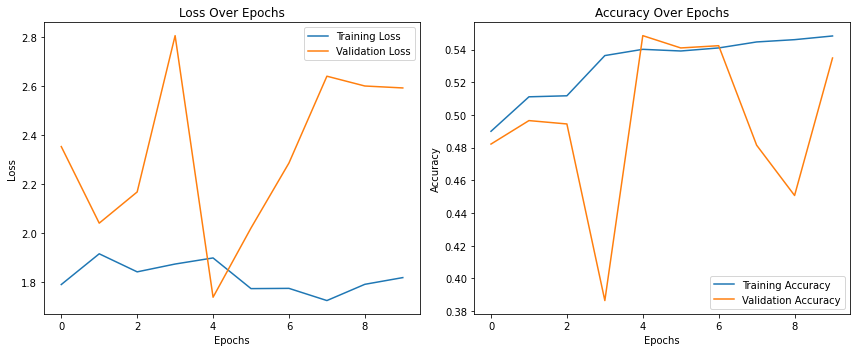

              precision    recall  f1-score   support

       anger     0.4198    0.2791    0.3353       516
     disgust     0.2857    0.0808    0.1260        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.4465    0.4303    0.4383       495
     neutral     0.6367    0.8941    0.7438      1615
     sadness     0.4021    0.1483    0.2167       263
    surprise     0.6471    0.3438    0.4490       352

    accuracy                         0.5791      3400
   macro avg     0.4054    0.3109    0.3298      3400
weighted avg     0.5376    0.5791    0.5349      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [49]:
model = EdgeGATWithSkipConnection(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
# model = EdgeGATWithGCN(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
model, train_losses, \
val_losses, train_accuracies, \
val_accuracies = train_egat_model(model, train_loader, val_loader)

show_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)

show_classification_report_egat_model(model, test_loader)

#### Maybe best model in turn 10?

In [50]:
best_model, best_params = tune_egat_model(EdgeGATWithSkipConnection, train_loader, val_loader, 768, 3, 4)

Training with params: {'lr': 0.01, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.74it/s]


Epoch 1: Train Loss = 1.2738353850712345, Val Loss = 1.3891105541476496, Train Acc = 0.5685358255451713, Val Acc = 0.5157318741450069


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.65it/s]


Epoch 2: Train Loss = 1.1860284047369432, Val Loss = 1.4406179566902142, Train Acc = 0.5935358255451714, Val Acc = 0.554719562243502


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.07it/s]


Epoch 3: Train Loss = 1.158699045784737, Val Loss = 1.408256324628989, Train Acc = 0.5955607476635514, Val Acc = 0.5082079343365253


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.71it/s]


Epoch 4: Train Loss = 1.1243516791542922, Val Loss = 1.3467909794714716, Train Acc = 0.6031931464174455, Val Acc = 0.5540355677154583


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.99it/s]


Epoch 5: Train Loss = 1.1149285598632155, Val Loss = 1.4621367655073603, Train Acc = 0.6070872274143302, Val Acc = 0.539671682626539


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.09it/s]


Epoch 6: Train Loss = 1.1157846489490044, Val Loss = 1.4588514823397551, Train Acc = 0.6096573208722741, Val Acc = 0.5567715458276333


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.13it/s]


Epoch 7: Train Loss = 1.100989625196585, Val Loss = 1.3684399426811271, Train Acc = 0.6086448598130841, Val Acc = 0.5649794801641587


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.50it/s]


Epoch 8: Train Loss = 1.0901734980268412, Val Loss = 1.5212951859390293, Train Acc = 0.6085669781931464, Val Acc = 0.542407660738714


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.89it/s]


Epoch 9: Train Loss = 1.0819070103901645, Val Loss = 1.4767241406426936, Train Acc = 0.6135514018691589, Val Acc = 0.5266757865937073
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 75.34it/s]


Epoch 1: Train Loss = 1.2547647007085658, Val Loss = 1.2910164455296818, Train Acc = 0.5700155763239876, Val Acc = 0.5615595075239398


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.11it/s]


Epoch 2: Train Loss = 1.1188860543348171, Val Loss = 1.2812314659633017, Train Acc = 0.6144859813084113, Val Acc = 0.5642954856361149


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.88it/s]


Epoch 3: Train Loss = 1.0758697770035792, Val Loss = 1.2778099736957638, Train Acc = 0.6219626168224299, Val Acc = 0.5704514363885089


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.33it/s]


Epoch 4: Train Loss = 1.0442674726299528, Val Loss = 1.314930847025028, Train Acc = 0.6311526479750779, Val Acc = 0.5615595075239398


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.59it/s]


Epoch 5: Train Loss = 1.0262946136571742, Val Loss = 1.3167092444030224, Train Acc = 0.633177570093458, Val Acc = 0.5683994528043775


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 69.66it/s]


Epoch 6: Train Loss = 1.0138746416558408, Val Loss = 1.313449030962807, Train Acc = 0.6365264797507788, Val Acc = 0.5786593707250342


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.10it/s]


Epoch 7: Train Loss = 0.9975435911772634, Val Loss = 1.416339368114455, Train Acc = 0.6437694704049844, Val Acc = 0.5595075239398085


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.11it/s]


Epoch 8: Train Loss = 0.987700019370661, Val Loss = 1.3163802747787148, Train Acc = 0.6399532710280373, Val Acc = 0.5745554035567716


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 67.53it/s]


Epoch 9: Train Loss = 0.9768237465423428, Val Loss = 1.327348450957625, Train Acc = 0.6447819314641745, Val Acc = 0.56703146374829


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.02it/s]


Epoch 10: Train Loss = 0.9661553483551231, Val Loss = 1.3040576091450122, Train Acc = 0.6471183800623053, Val Acc = 0.5711354309165527


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 69.18it/s]


Epoch 11: Train Loss = 0.9567498873199198, Val Loss = 1.3554209179624364, Train Acc = 0.65, Val Acc = 0.5554035567715458


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.92it/s]


Epoch 12: Train Loss = 0.9420093213268383, Val Loss = 1.3494786321013061, Train Acc = 0.6537383177570093, Val Acc = 0.5629274965800274


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.12it/s]


Epoch 13: Train Loss = 0.9344445149440112, Val Loss = 1.3292567837914382, Train Acc = 0.6549844236760125, Val Acc = 0.56703146374829
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 76.00it/s]


Epoch 1: Train Loss = 1.2588604048584346, Val Loss = 1.293942870668791, Train Acc = 0.5688473520249221, Val Acc = 0.5601915184678523


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 69.85it/s]


Epoch 2: Train Loss = 1.1209488171877133, Val Loss = 1.27826370400963, Train Acc = 0.6120716510903427, Val Acc = 0.5636114911080712


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.79it/s]


Epoch 3: Train Loss = 1.0774310776877596, Val Loss = 1.2764397044976552, Train Acc = 0.6221183800623052, Val Acc = 0.5690834473324213


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.90it/s]


Epoch 4: Train Loss = 1.0470917152383157, Val Loss = 1.3079128645291482, Train Acc = 0.6330218068535826, Val Acc = 0.5588235294117647


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.33it/s]


Epoch 5: Train Loss = 1.0289063839931731, Val Loss = 1.3154986542960008, Train Acc = 0.6336448598130842, Val Acc = 0.5656634746922025


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.49it/s]


Epoch 6: Train Loss = 1.0187167313838101, Val Loss = 1.2969872854787994, Train Acc = 0.6352803738317757, Val Acc = 0.5683994528043775


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.99it/s]


Epoch 7: Train Loss = 1.0001667062286288, Val Loss = 1.3957586059174327, Train Acc = 0.6421339563862928, Val Acc = 0.5649794801641587


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.46it/s]


Epoch 8: Train Loss = 0.9919820560970241, Val Loss = 1.3054678299360805, Train Acc = 0.6425233644859814, Val Acc = 0.5759233926128591


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.65it/s]


Epoch 9: Train Loss = 0.9790730030370738, Val Loss = 1.3142864982838984, Train Acc = 0.6427570093457944, Val Acc = 0.560875512995896


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.02it/s]


Epoch 10: Train Loss = 0.9675913658769181, Val Loss = 1.295762729630978, Train Acc = 0.6445482866043614, Val Acc = 0.5766073871409029


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.26it/s]


Epoch 11: Train Loss = 0.957738617546339, Val Loss = 1.3410120824144947, Train Acc = 0.6541277258566979, Val Acc = 0.5636114911080712


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.11it/s]


Epoch 12: Train Loss = 0.9433888634617216, Val Loss = 1.3307812432999964, Train Acc = 0.6536604361370717, Val Acc = 0.5718194254445964


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 70.42it/s]


Epoch 13: Train Loss = 0.9355068967641812, Val Loss = 1.3247231909867239, Train Acc = 0.6583333333333333, Val Acc = 0.5690834473324213
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.27it/s]


Epoch 1: Train Loss = 4.328979357642709, Val Loss = 2.880437861327772, Train Acc = 0.3673676012461059, Val Acc = 0.33036935704514364


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.38it/s]


Epoch 2: Train Loss = 5.363135802735816, Val Loss = 3.362418217129863, Train Acc = 0.3750778816199377, Val Acc = 0.4521203830369357


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.42it/s]


Epoch 3: Train Loss = 4.607597931028793, Val Loss = 4.192652833822218, Train Acc = 0.38294392523364484, Val Acc = 0.36114911080711354


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 65.28it/s]


Epoch 4: Train Loss = 4.889625354662988, Val Loss = 3.8818295430424903, Train Acc = 0.3655763239875389, Val Acc = 0.42544459644322846


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.85it/s]


Epoch 5: Train Loss = 4.614927752246701, Val Loss = 3.7633375352920364, Train Acc = 0.394392523364486, Val Acc = 0.393296853625171


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.93it/s]


Epoch 6: Train Loss = 10.860137676893377, Val Loss = 3.0837349705703536, Train Acc = 0.40186915887850466, Val Acc = 0.4117647058823529
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 74.80it/s]


Epoch 1: Train Loss = 1.256866180965746, Val Loss = 1.2908048079797516, Train Acc = 0.5667445482866044, Val Acc = 0.5622435020519836


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.82it/s]


Epoch 2: Train Loss = 1.1194631458863753, Val Loss = 1.2793691878241522, Train Acc = 0.6139408099688474, Val Acc = 0.5629274965800274


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.42it/s]


Epoch 3: Train Loss = 1.075442838673135, Val Loss = 1.280844686318327, Train Acc = 0.6200155763239875, Val Acc = 0.5683994528043775


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.88it/s]


Epoch 4: Train Loss = 1.0443090923397835, Val Loss = 1.3139252570423263, Train Acc = 0.6303738317757009, Val Acc = 0.5601915184678523


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 69.80it/s]


Epoch 5: Train Loss = 1.0263479964272981, Val Loss = 1.3127328255593225, Train Acc = 0.6322429906542056, Val Acc = 0.5656634746922025


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 69.19it/s]


Epoch 6: Train Loss = 1.0156354421422022, Val Loss = 1.3098540299675532, Train Acc = 0.6351246105919003, Val Acc = 0.5725034199726402


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.42it/s]


Epoch 7: Train Loss = 0.996260304867152, Val Loss = 1.4042011198277276, Train Acc = 0.6427570093457944, Val Acc = 0.554719562243502
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5786593707250342


In [51]:
show_classification_report_egat_model(best_model, test_loader)

              precision    recall  f1-score   support

       anger     0.5229    0.3760    0.4374       516
     disgust     0.0000    0.0000    0.0000        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.4762    0.5657    0.5171       495
     neutral     0.7233    0.8192    0.7683      1615
     sadness     0.3351    0.2395    0.2794       263
    surprise     0.4738    0.5653    0.5155       352

    accuracy                         0.6056      3400
   macro avg     0.3616    0.3665    0.3597      3400
weighted avg     0.5673    0.6056    0.5816      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [52]:
best_model, best_params = tune_egat_model(EdgeGATWithGCN, train_loader, val_loader, 768, 3, 4)
show_classification_report_egat_model(best_model, test_loader)

Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.29it/s]


Epoch 1: Train Loss = 1.275811641494295, Val Loss = 1.3356736398957394, Train Acc = 0.5692367601246106, Val Acc = 0.551983584131327


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 88.47it/s]


Epoch 2: Train Loss = 1.1286620446601539, Val Loss = 1.2847240658821883, Train Acc = 0.6103582554517134, Val Acc = 0.5882352941176471


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.49it/s]


Epoch 3: Train Loss = 1.0830230824735567, Val Loss = 1.337618773703084, Train Acc = 0.6238317757009346, Val Acc = 0.5752393980848153


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.74it/s]


Epoch 4: Train Loss = 1.0619061353564676, Val Loss = 1.309905234310362, Train Acc = 0.6259345794392523, Val Acc = 0.5656634746922025


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.61it/s]


Epoch 5: Train Loss = 1.0392106833453807, Val Loss = 1.3039195844420681, Train Acc = 0.6321651090342679, Val Acc = 0.5554035567715458


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.01it/s]


Epoch 6: Train Loss = 1.0209739780691625, Val Loss = 1.2799594307663265, Train Acc = 0.6359034267912772, Val Acc = 0.5752393980848153


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.49it/s]


Epoch 7: Train Loss = 1.0042607123058083, Val Loss = 1.3111981725251234, Train Acc = 0.6397196261682243, Val Acc = 0.5615595075239398


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 88.64it/s]


Epoch 8: Train Loss = 0.9871016011694101, Val Loss = 1.301956876753657, Train Acc = 0.645404984423676, Val Acc = 0.5725034199726402


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.41it/s]


Epoch 9: Train Loss = 0.9740663264287395, Val Loss = 1.2972871128469705, Train Acc = 0.647196261682243, Val Acc = 0.5752393980848153


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.03it/s]


Epoch 10: Train Loss = 0.9627085921764201, Val Loss = 1.3405165288873293, Train Acc = 0.6495327102803738, Val Acc = 0.5636114911080712


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.57it/s]


Epoch 11: Train Loss = 0.9513728267021684, Val Loss = 1.3209818498817858, Train Acc = 0.6524922118380062, Val Acc = 0.5745554035567716


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.69it/s]


Epoch 12: Train Loss = 0.9413114821762536, Val Loss = 1.3414560810559326, Train Acc = 0.6524143302180685, Val Acc = 0.5601915184678523


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.68it/s]


Epoch 13: Train Loss = 0.9279432169661892, Val Loss = 1.3803500626926068, Train Acc = 0.660202492211838, Val Acc = 0.5499316005471956


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.27it/s]


Epoch 14: Train Loss = 0.9206676974651162, Val Loss = 1.4081161451284532, Train Acc = 0.6609034267912772, Val Acc = 0.5253077975376197


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.86it/s]


Epoch 15: Train Loss = 0.9089263997478324, Val Loss = 1.3854759652305533, Train Acc = 0.6633177570093458, Val Acc = 0.5581395348837209


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.93it/s]


Epoch 16: Train Loss = 0.8997644283812002, Val Loss = 1.3520764840283879, Train Acc = 0.6710280373831776, Val Acc = 0.5574555403556771
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 98.01it/s]


Epoch 1: Train Loss = 1.2742848040156618, Val Loss = 1.354099133224399, Train Acc = 0.5674454828660436, Val Acc = 0.5458276333789329


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.44it/s]


Epoch 2: Train Loss = 1.1284167679388903, Val Loss = 1.287021796833034, Train Acc = 0.6111370716510903, Val Acc = 0.5868673050615595


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.05it/s]


Epoch 3: Train Loss = 1.083971077648716, Val Loss = 1.3501880141285558, Train Acc = 0.6217289719626168, Val Acc = 0.5656634746922025


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.38it/s]


Epoch 4: Train Loss = 1.0599955539839963, Val Loss = 1.311849220883515, Train Acc = 0.6265576323987538, Val Acc = 0.56703146374829


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.21it/s]


Epoch 5: Train Loss = 1.038570264654441, Val Loss = 1.3145047084048942, Train Acc = 0.6318535825545172, Val Acc = 0.5506155950752394


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 95.14it/s]


Epoch 6: Train Loss = 1.0230949288156503, Val Loss = 1.281754811315073, Train Acc = 0.6348130841121495, Val Acc = 0.579343365253078


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.10it/s]


Epoch 7: Train Loss = 1.0065327617977917, Val Loss = 1.3346632183425957, Train Acc = 0.6388629283489097, Val Acc = 0.5581395348837209


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.14it/s]


Epoch 8: Train Loss = 0.9883575075305998, Val Loss = 1.3184490945328164, Train Acc = 0.6443925233644859, Val Acc = 0.5827633378932968


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.62it/s]


Epoch 9: Train Loss = 0.9776266664232093, Val Loss = 1.3031954292897825, Train Acc = 0.6441588785046729, Val Acc = 0.5711354309165527


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.62it/s]


Epoch 10: Train Loss = 0.965631899798151, Val Loss = 1.3344326887003801, Train Acc = 0.6475856697819314, Val Acc = 0.5690834473324213


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.15it/s]


Epoch 11: Train Loss = 0.9549920300151118, Val Loss = 1.319866696903827, Train Acc = 0.6513239875389408, Val Acc = 0.5752393980848153
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.11it/s]


Epoch 1: Train Loss = 1.2741711397758788, Val Loss = 1.3596632967392603, Train Acc = 0.5702492211838006, Val Acc = 0.5458276333789329


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 93.96it/s]


Epoch 2: Train Loss = 1.1295093341290743, Val Loss = 1.2889805222689001, Train Acc = 0.6113707165109035, Val Acc = 0.5875512995896033


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.65it/s]


Epoch 3: Train Loss = 1.0822903550057499, Val Loss = 1.3408604408993765, Train Acc = 0.6248442367601246, Val Acc = 0.5766073871409029


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.65it/s]


Epoch 4: Train Loss = 1.0587623878847807, Val Loss = 1.3263150165616362, Train Acc = 0.625, Val Acc = 0.5649794801641587


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.43it/s]


Epoch 5: Train Loss = 1.0370781980196222, Val Loss = 1.3055120957946336, Train Acc = 0.6306853582554517, Val Acc = 0.5567715458276333


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 93.96it/s]


Epoch 6: Train Loss = 1.0240066655704545, Val Loss = 1.2858459771369342, Train Acc = 0.634968847352025, Val Acc = 0.5820793433652531


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.17it/s]


Epoch 7: Train Loss = 1.0074066259682661, Val Loss = 1.3173197734687063, Train Acc = 0.6393302180685358, Val Acc = 0.5595075239398085


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 93.90it/s]


Epoch 8: Train Loss = 0.9901148219109961, Val Loss = 1.3122594898773565, Train Acc = 0.6433021806853583, Val Acc = 0.573187414500684


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.75it/s]


Epoch 9: Train Loss = 0.9788042296974541, Val Loss = 1.301651947145109, Train Acc = 0.6458722741433022, Val Acc = 0.5718194254445964


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.16it/s]


Epoch 10: Train Loss = 0.9682905937139704, Val Loss = 1.3230304507745636, Train Acc = 0.6485981308411215, Val Acc = 0.5738714090287278


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 90.34it/s]


Epoch 11: Train Loss = 0.9569832922416498, Val Loss = 1.3136714561393967, Train Acc = 0.6507788161993769, Val Acc = 0.573187414500684
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 30, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 91.71it/s]


Epoch 1: Train Loss = 1.2834085252739627, Val Loss = 1.468093775295549, Train Acc = 0.5609034267912772, Val Acc = 0.5287277701778386


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.98it/s]


Epoch 2: Train Loss = 1.1939298098889628, Val Loss = 1.3879646831847452, Train Acc = 0.5923676012461059, Val Acc = 0.554719562243502


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 87.67it/s]


Epoch 3: Train Loss = 1.1623312140931374, Val Loss = 1.3310120001297305, Train Acc = 0.5951713395638629, Val Acc = 0.5697674418604651


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.67it/s]


Epoch 4: Train Loss = 1.1380709790999795, Val Loss = 1.5142894133511517, Train Acc = 0.5969626168224299, Val Acc = 0.5369357045143639


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 88.69it/s]


Epoch 5: Train Loss = 1.123686843101556, Val Loss = 1.4530270536740622, Train Acc = 0.6044392523364486, Val Acc = 0.5259917920656635


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 88.18it/s]


Epoch 6: Train Loss = 1.111010779674096, Val Loss = 1.5187706405158947, Train Acc = 0.6049065420560747, Val Acc = 0.5383036935704515


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:27<00:00, 79.06it/s]


Epoch 7: Train Loss = 1.1018788814872365, Val Loss = 1.5696007646344325, Train Acc = 0.6086448598130841, Val Acc = 0.4801641586867305


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:24<00:00, 89.06it/s]


Epoch 8: Train Loss = 1.0838504626758447, Val Loss = 1.359399651211721, Train Acc = 0.6117601246105919, Val Acc = 0.5383036935704515
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 25, 'early_stop_threshold': 0.001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 97.50it/s]


Epoch 1: Train Loss = 4.371291365429597, Val Loss = 2.8687566209905695, Train Acc = 0.3762461059190031, Val Acc = 0.4521203830369357


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:22<00:00, 94.03it/s]


Epoch 2: Train Loss = 5.0557644542790445, Val Loss = 11.337845392470006, Train Acc = 0.37095015576323986, Val Acc = 0.20861833105335156


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.29it/s]


Epoch 3: Train Loss = 4.906562297859427, Val Loss = 3.654772878383045, Train Acc = 0.3724299065420561, Val Acc = 0.28454172366621067


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 91.44it/s]


Epoch 4: Train Loss = 4.7503773347145914, Val Loss = 8.232725892591946, Train Acc = 0.36705607476635516, Val Acc = 0.3796169630642955


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.75it/s]


Epoch 5: Train Loss = 6.254402701937264, Val Loss = 2.7747627621999493, Train Acc = 0.3745327102803738, Val Acc = 0.40287277701778385


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.42it/s]


Epoch 6: Train Loss = 3.93433559399313, Val Loss = 14.70675960457237, Train Acc = 0.3940809968847352, Val Acc = 0.1853625170998632


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.61it/s]


Epoch 7: Train Loss = 5.6455501170576925, Val Loss = 4.141878517239389, Train Acc = 0.3838006230529595, Val Acc = 0.26880984952120385


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.09it/s]


Epoch 8: Train Loss = 4.87880165528868, Val Loss = 4.175352551332779, Train Acc = 0.39221183800623055, Val Acc = 0.13885088919288646


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.03it/s]


Epoch 9: Train Loss = 5.153292873277237, Val Loss = 4.339904921075975, Train Acc = 0.3866822429906542, Val Acc = 0.41997264021887826


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:23<00:00, 92.69it/s]


Epoch 10: Train Loss = 4.079271312565037, Val Loss = 8.326206520851702, Train Acc = 0.39922118380062305, Val Acc = 0.16142270861833105
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}, Best validation accuracy: 0.5882352941176471
              precision    recall  f1-score   support

       anger     0.4976    0.3973    0.4418       516
     disgust     0.2500    0.0202    0.0374        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.4873    0.5051    0.4960       495
     neutral     0.7155    0.8347    0.7705      1615
     sadness     0.3439    0.2053    0.2571       263
    surprise     0.4507    0.5455    0.4936       352

    accuracy                         0.6032      3400
   macro avg     0.3922    0.3583    0.3566      3400
weighted avg     0.5669    0.6032    0.5773      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [53]:
best_model, best_params = tune_egat_model(Edge2GATWithGCN, train_loader, val_loader, 768, 3, 4)
show_classification_report_egat_model(best_model, test_loader)

Training with params: {'lr': 0.001, 'num_epochs': 30, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.55it/s]


Epoch 1: Train Loss = 1.2654674097516194, Val Loss = 1.3184400226506923, Train Acc = 0.5748442367601246, Val Acc = 0.5581395348837209


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.85it/s]


Epoch 2: Train Loss = 1.1246962483092728, Val Loss = 1.2814785583910566, Train Acc = 0.6153426791277259, Val Acc = 0.5813953488372093


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 67.10it/s]


Epoch 3: Train Loss = 1.084827380694656, Val Loss = 1.342134663241881, Train Acc = 0.6248442367601246, Val Acc = 0.56703146374829


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 67.52it/s]


Epoch 4: Train Loss = 1.0643980594093188, Val Loss = 1.2981776763581567, Train Acc = 0.6274143302180686, Val Acc = 0.573187414500684


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 67.52it/s]


Epoch 5: Train Loss = 1.0476639748740666, Val Loss = 1.3091453562180202, Train Acc = 0.630607476635514, Val Acc = 0.5540355677154583


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.79it/s]


Epoch 6: Train Loss = 1.036997961456439, Val Loss = 1.2677539247191614, Train Acc = 0.632398753894081, Val Acc = 0.579343365253078


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.62it/s]


Epoch 7: Train Loss = 1.024321537457096, Val Loss = 1.3170866245886794, Train Acc = 0.6357476635514019, Val Acc = 0.5526675786593708


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.18it/s]


Epoch 8: Train Loss = 1.0107106410605073, Val Loss = 1.3037346164385477, Train Acc = 0.6371495327102804, Val Acc = 0.5663474692202463


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.45it/s]


Epoch 9: Train Loss = 1.002263899359645, Val Loss = 1.2951421518292692, Train Acc = 0.6404205607476635, Val Acc = 0.5745554035567716


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.57it/s]


Epoch 10: Train Loss = 0.9942663569279291, Val Loss = 1.3135537965016233, Train Acc = 0.6399532710280373, Val Acc = 0.5752393980848153


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.73it/s]


Epoch 11: Train Loss = 0.9860729190676163, Val Loss = 1.310102840554383, Train Acc = 0.6432242990654206, Val Acc = 0.5759233926128591


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.19it/s]


Epoch 12: Train Loss = 0.9797868176492759, Val Loss = 1.3285870010516159, Train Acc = 0.6425233644859814, Val Acc = 0.5588235294117647


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.44it/s]


Epoch 13: Train Loss = 0.9699464818048809, Val Loss = 1.3582642773787181, Train Acc = 0.6461059190031153, Val Acc = 0.5410396716826266


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.95it/s]


Epoch 14: Train Loss = 0.9676314316983162, Val Loss = 1.3875006088228137, Train Acc = 0.6464174454828661, Val Acc = 0.5369357045143639


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.11it/s]


Epoch 15: Train Loss = 0.9591647367476037, Val Loss = 1.3595641844457498, Train Acc = 0.6485981308411215, Val Acc = 0.56703146374829


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.32it/s]


Epoch 16: Train Loss = 0.9553399324831036, Val Loss = 1.3207815836149233, Train Acc = 0.6507788161993769, Val Acc = 0.5533515731874145
Early stopping triggered
Training with params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.36it/s]


Epoch 1: Train Loss = 1.267397674518051, Val Loss = 1.3224726512200302, Train Acc = 0.5756230529595016, Val Acc = 0.5581395348837209


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.93it/s]


Epoch 2: Train Loss = 1.126355191665115, Val Loss = 1.2837342770080324, Train Acc = 0.6135514018691589, Val Acc = 0.5848153214774282


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.56it/s]


Epoch 3: Train Loss = 1.0837793852219841, Val Loss = 1.3450018321681354, Train Acc = 0.6238317757009346, Val Acc = 0.5636114911080712


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.23it/s]


Epoch 4: Train Loss = 1.0640324251674529, Val Loss = 1.2973209508453254, Train Acc = 0.6273364485981309, Val Acc = 0.5711354309165527


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.02it/s]


Epoch 5: Train Loss = 1.0477531263190838, Val Loss = 1.3075045538169365, Train Acc = 0.6309968847352025, Val Acc = 0.554719562243502


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.63it/s]


Epoch 6: Train Loss = 1.03700908144798, Val Loss = 1.2670063633540714, Train Acc = 0.6322429906542056, Val Acc = 0.5800273597811217


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.64it/s]


Epoch 7: Train Loss = 1.0244144806146829, Val Loss = 1.3164183719842522, Train Acc = 0.6360591900311526, Val Acc = 0.5533515731874145


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.81it/s]


Epoch 8: Train Loss = 1.0107819278448544, Val Loss = 1.3036632931756753, Train Acc = 0.636993769470405, Val Acc = 0.5656634746922025


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.11it/s]


Epoch 9: Train Loss = 1.002332247992874, Val Loss = 1.294770013941107, Train Acc = 0.639797507788162, Val Acc = 0.5752393980848153


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.06it/s]


Epoch 10: Train Loss = 0.9942643104992048, Val Loss = 1.313289261540329, Train Acc = 0.6399532710280373, Val Acc = 0.5752393980848153


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.03it/s]


Epoch 11: Train Loss = 0.9861331855947221, Val Loss = 1.3097558561850478, Train Acc = 0.6426791277258567, Val Acc = 0.5759233926128591
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:32<00:00, 66.68it/s]


Epoch 1: Train Loss = 1.2689253123787543, Val Loss = 1.4790282666959145, Train Acc = 0.5701713395638629, Val Acc = 0.53077975376197


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.86it/s]


Epoch 2: Train Loss = 1.1918961763399205, Val Loss = 1.3999508955619402, Train Acc = 0.5927570093457943, Val Acc = 0.554719562243502


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.75it/s]


Epoch 3: Train Loss = 1.1609608307075514, Val Loss = 1.3290609061649, Train Acc = 0.5954828660436137, Val Acc = 0.5683994528043775


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.94it/s]


Epoch 4: Train Loss = 1.1404383696387177, Val Loss = 1.5011339983316483, Train Acc = 0.5954828660436137, Val Acc = 0.5348837209302325


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.79it/s]


Epoch 5: Train Loss = 1.1236650407331548, Val Loss = 1.4659744125135519, Train Acc = 0.6024922118380063, Val Acc = 0.5259917920656635


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.97it/s]


Epoch 6: Train Loss = 1.1096647039581848, Val Loss = 1.507810435609685, Train Acc = 0.6047507788161994, Val Acc = 0.5437756497948016


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.49it/s]


Epoch 7: Train Loss = 1.1025213669606104, Val Loss = 1.5656069987074093, Train Acc = 0.6066978193146417, Val Acc = 0.48084815321477425


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.47it/s]


Epoch 8: Train Loss = 1.083627531167844, Val Loss = 1.3718286283866123, Train Acc = 0.6124610591900311, Val Acc = 0.5417236662106704
Early stopping triggered
Training with params: {'lr': 0.01, 'num_epochs': 20, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.99it/s]


Epoch 1: Train Loss = 1.2674804177773358, Val Loss = 1.4779652873675029, Train Acc = 0.5710280373831775, Val Acc = 0.5287277701778386


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.61it/s]


Epoch 2: Train Loss = 1.1919751425187484, Val Loss = 1.4023041613193021, Train Acc = 0.5923676012461059, Val Acc = 0.5554035567715458


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.48it/s]


Epoch 3: Train Loss = 1.1611280113954476, Val Loss = 1.32960311330303, Train Acc = 0.5955607476635514, Val Acc = 0.5683994528043775


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.30it/s]


Epoch 4: Train Loss = 1.140185637185264, Val Loss = 1.5020570817437988, Train Acc = 0.5955607476635514, Val Acc = 0.5355677154582763


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 58.74it/s]


Epoch 5: Train Loss = 1.1236556733320295, Val Loss = 1.4628546746378694, Train Acc = 0.6025700934579439, Val Acc = 0.5280437756497948


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.00it/s]


Epoch 6: Train Loss = 1.109719264906555, Val Loss = 1.5110485481443228, Train Acc = 0.6047507788161994, Val Acc = 0.542407660738714


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.64it/s]


Epoch 7: Train Loss = 1.1026014655336944, Val Loss = 1.5676689303031675, Train Acc = 0.607398753894081, Val Acc = 0.478796169630643


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 61.75it/s]


Epoch 8: Train Loss = 1.08360514072572, Val Loss = 1.3724492234350354, Train Acc = 0.613006230529595, Val Acc = 0.5417236662106704
Early stopping triggered
Training with params: {'lr': 0.1, 'num_epochs': 20, 'early_stop_threshold': 0.0005, 'max_no_improve_epochs': 10}


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.47it/s]


Epoch 1: Train Loss = 4.218513129950077, Val Loss = 2.5273029218393344, Train Acc = 0.365809968847352, Val Acc = 0.4110807113543092


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.24it/s]


Epoch 2: Train Loss = 4.944302699352633, Val Loss = 6.492606221236013, Train Acc = 0.3813084112149533, Val Acc = 0.25170998632010944


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.12it/s]


Epoch 3: Train Loss = 4.724570429110165, Val Loss = 5.253867267744392, Train Acc = 0.38029595015576323, Val Acc = 0.22845417236662108


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.69it/s]


Epoch 4: Train Loss = 4.943724831475388, Val Loss = 6.96198467629555, Train Acc = 0.39042056074766357, Val Acc = 0.3987688098495212


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.84it/s]


Epoch 5: Train Loss = 4.83811348542484, Val Loss = 2.479416878245495, Train Acc = 0.3835669781931464, Val Acc = 0.3707250341997264


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.86it/s]


Epoch 6: Train Loss = 5.282650749082465, Val Loss = 3.9333591615160306, Train Acc = 0.39166666666666666, Val Acc = 0.19699042407660738


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.67it/s]


Epoch 7: Train Loss = 4.6255490831600765, Val Loss = 4.376994697363289, Train Acc = 0.39026479750778814, Val Acc = 0.24623803009575923


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.85it/s]


Epoch 8: Train Loss = 4.879759406230903, Val Loss = 16.354545008584306, Train Acc = 0.39602803738317754, Val Acc = 0.16484268125854992


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.34it/s]


Epoch 9: Train Loss = 4.924955206256117, Val Loss = 2.197189452719909, Train Acc = 0.39182242990654204, Val Acc = 0.43502051983584133


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.32it/s]


Epoch 10: Train Loss = 5.409399843475806, Val Loss = 6.8207981518021334, Train Acc = 0.40677570093457943, Val Acc = 0.20588235294117646


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.25it/s]


Epoch 11: Train Loss = 5.2304262200216165, Val Loss = 5.271401806425746, Train Acc = 0.3891744548286604, Val Acc = 0.3173734610123119


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.15it/s]


Epoch 12: Train Loss = 4.961096644949857, Val Loss = 4.266500671083729, Train Acc = 0.393613707165109, Val Acc = 0.30437756497948015


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.27it/s]


Epoch 13: Train Loss = 4.836782410282696, Val Loss = 3.7032051746595513, Train Acc = 0.39758566978193144, Val Acc = 0.33105335157318744


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 64.10it/s]


Epoch 14: Train Loss = 5.336663886990735, Val Loss = 3.2162875382712595, Train Acc = 0.40077881619937694, Val Acc = 0.280437756497948


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 63.12it/s]


Epoch 15: Train Loss = 4.8016959903939505, Val Loss = 4.181467346191466, Train Acc = 0.41285046728971964, Val Acc = 0.4015047879616963


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.55it/s]


Epoch 16: Train Loss = 4.57963479714125, Val Loss = 5.309667656225739, Train Acc = 0.39369158878504673, Val Acc = 0.32489740082079344


Epoch 17: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:34<00:00, 62.36it/s]


Epoch 17: Train Loss = 5.341475262129332, Val Loss = 3.198918490598185, Train Acc = 0.3989096573208723, Val Acc = 0.4131326949384405


Epoch 18: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 61.67it/s]


Epoch 18: Train Loss = 4.6265360780242855, Val Loss = 3.4718833324257976, Train Acc = 0.4057632398753894, Val Acc = 0.44049247606019154


Epoch 19: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:33<00:00, 63.77it/s]


Epoch 19: Train Loss = 4.859606254428856, Val Loss = 3.303711337685861, Train Acc = 0.3955607476635514, Val Acc = 0.41381668946648426
Early stopping triggered
Best params: {'lr': 0.001, 'num_epochs': 25, 'early_stop_threshold': 0.0001, 'max_no_improve_epochs': 5}, Best validation accuracy: 0.5848153214774282
              precision    recall  f1-score   support

       anger     0.5486    0.3062    0.3930       516
     disgust     0.0000    0.0000    0.0000        99
        fear     0.0000    0.0000    0.0000        60
         joy     0.4813    0.5212    0.5005       495
     neutral     0.7012    0.8836    0.7819      1615
     sadness     0.3913    0.1711    0.2381       263
    surprise     0.4577    0.5540    0.5013       352

    accuracy                         0.6126      3400
   macro avg     0.3686    0.3480    0.3450      3400
weighted avg     0.5641    0.6126    0.5742      3400



C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\edayo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

#### Get the predicted labels for later analysis

In [33]:
model = EdgeGATWithGCN(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
model, _, _, _, val_accuracies = train_egat_model(
    model,
    train_loader,
    val_loader,
    lr=0.001,
    num_epochs=25,
    early_stop_threshold=0.0001,
    max_no_improve_epochs=10
)

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 74.12it/s]


Epoch 1: Train Loss = 1.220459636123161, Val Loss = 1.3093878922087174, Train Acc = 0.5845794392523365, Val Acc = 0.5526675786593708


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 74.40it/s]


Epoch 2: Train Loss = 1.098913709940044, Val Loss = 1.3213127807334617, Train Acc = 0.6140186915887851, Val Acc = 0.5581395348837209


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 74.10it/s]


Epoch 3: Train Loss = 1.058998371007059, Val Loss = 1.3045087505476893, Train Acc = 0.6193146417445483, Val Acc = 0.5718194254445964


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.13it/s]


Epoch 4: Train Loss = 1.0251433670645822, Val Loss = 1.511959434469679, Train Acc = 0.6290498442367601, Val Acc = 0.5512995896032832


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 67.95it/s]


Epoch 5: Train Loss = 1.000955396352974, Val Loss = 1.2945262187333018, Train Acc = 0.6348130841121495, Val Acc = 0.5752393980848153


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.61it/s]


Epoch 6: Train Loss = 0.9690013983585501, Val Loss = 1.3022432419298975, Train Acc = 0.634968847352025, Val Acc = 0.5704514363885089


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.73it/s]


Epoch 7: Train Loss = 0.9413104401917534, Val Loss = 1.3565079179902872, Train Acc = 0.6477414330218069, Val Acc = 0.5629274965800274


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 74.78it/s]


Epoch 8: Train Loss = 0.9150678565721911, Val Loss = 1.4128989946718018, Train Acc = 0.6493769470404984, Val Acc = 0.5683994528043775


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 73.13it/s]


Epoch 9: Train Loss = 0.8938236013598119, Val Loss = 1.412070898104597, Train Acc = 0.6544392523364486, Val Acc = 0.5437756497948016


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:29<00:00, 72.19it/s]


Epoch 10: Train Loss = 0.8654457128379834, Val Loss = 1.4286432420214017, Train Acc = 0.6677570093457944, Val Acc = 0.5622435020519836


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.53it/s]


Epoch 11: Train Loss = 0.8456978953810499, Val Loss = 1.4825101665600582, Train Acc = 0.6726635514018692, Val Acc = 0.5512995896032832


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:28<00:00, 74.60it/s]


Epoch 12: Train Loss = 0.829899877319743, Val Loss = 1.5139437513650154, Train Acc = 0.6752336448598131, Val Acc = 0.5629274965800274


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:31<00:00, 68.38it/s]


Epoch 13: Train Loss = 0.806240716604171, Val Loss = 1.423000064023115, Train Acc = 0.6805295950155763, Val Acc = 0.5540355677154583


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.50it/s]


Epoch 14: Train Loss = 0.7846227243456463, Val Loss = 1.4669332099319607, Train Acc = 0.6884735202492211, Val Acc = 0.5471956224350205


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:30<00:00, 71.08it/s]


Epoch 15: Train Loss = 0.769262934675996, Val Loss = 1.4765178268206203, Train Acc = 0.692367601246106, Val Acc = 0.542407660738714
Early stopping triggered
              precision    recall  f1-score   support

       anger     0.4406    0.4167    0.4283       516
     disgust     0.2895    0.1111    0.1606        99
        fear     0.1509    0.1333    0.1416        60
         joy     0.4332    0.5434    0.4821       495
     neutral     0.7337    0.7387    0.7362      1615
     sadness     0.3000    0.1939    0.2356       263
    surprise     0.4356    0.5000    0.4656       352

    accuracy                         0.5656      3400
   macro avg     0.3976    0.3767    0.3786      3400
weighted avg     0.5578    0.5656    0.5585      3400



In [35]:
show_classification_report_egat_model(model, test_loader)

              precision    recall  f1-score   support

       anger     0.4406    0.4167    0.4283       516
     disgust     0.2895    0.1111    0.1606        99
        fear     0.1509    0.1333    0.1416        60
         joy     0.4332    0.5434    0.4821       495
     neutral     0.7337    0.7387    0.7362      1615
     sadness     0.3000    0.1939    0.2356       263
    surprise     0.4356    0.5000    0.4656       352

    accuracy                         0.5656      3400
   macro avg     0.3976    0.3767    0.3786      3400
weighted avg     0.5578    0.5656    0.5585      3400



### Exatract TP, indices, and embeddings

In [29]:
def train_egat_model_and_get_tp(model, train_loader, val_loader, lr=0.01, num_epochs=25, early_stop_threshold=0.0001, max_no_improve_epochs=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0


        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            optimizer.zero_grad()
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out, _ = model(graph, data.x, edge_feats)

            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            preds = out.argmax(dim=1)
            correct_train += (preds == data.y).sum().item()
            total_train += data.y.size(0)

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data in val_loader:
                graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
                edge_feats = get_ohe(data.edge_type)
                out, _ = model(graph, data.x , edge_feats)
                print(out.shape)
                loss = criterion(out, data.y)
                val_loss += loss.item()

                preds = out.argmax(dim=1)
                correct_val += (preds == data.y).sum().item()
                total_val += data.y.size(0)

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val)

        print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]}, Val Loss = {val_losses[-1]}, Train Acc = {train_accuracies[-1]}, Val Acc = {val_accuracies[-1]}")

        if best_val_loss - val_losses[-1] < early_stop_threshold:
            no_improve_epochs += 1
            if no_improve_epochs >= max_no_improve_epochs:
                print("Early stopping triggered")
                break
        else:
            no_improve_epochs = 0
            best_val_loss = val_losses[-1]
            
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [31]:
# class EdgeGATWithSkipConnectionAndGetTP(nn.Module):
#     def __init__(self, in_node_feats, in_edge_feats=3, out_node_feats=64, out_edge_feats=3, num_heads=4, num_classes=7):
#         super(EdgeGATWithSkipConnectionAndGetTP, self).__init__()
#         self.egat1 = EGATConv(in_node_feats, in_edge_feats, out_node_feats, out_edge_feats, num_heads)
#         self.egat2 = EGATConv(out_node_feats, out_edge_feats, out_node_feats, out_edge_feats, num_heads)
#         self.skip_transformation = nn.Linear(in_node_feats, out_node_feats)
#         self.fc = nn.Linear(out_node_feats, num_classes)

#     def forward(self, graph, nfeats, efeats):
#         # Add self-loops to edge_index and adjust edge_attr accordingly if needed
# #         print(f"nfeats shape: {nfeats.shape}")
#         x_skip = self.skip_transformation(nfeats)  # Transform the input for the skip connection
#         x, e = self.egat1(graph, nfeats, efeats)
#         x = x.max(dim=1).values  # Aggregate over heads
#         x = F.relu(x)
#         x, e = self.egat2(graph, x, efeats)  # Ensure x is reshaped properly
#         x = x.max(dim=1).values  # Aggregate over heads
        
#         x += x_skip  # Add skip connection
#         x_copy = x
#         x = self.fc(x)
#         return F.log_softmax(x, dim=1), x_copy

In [34]:
def show_classification_report_egat_model_and_get_tp(model, test_loader):
    # Classification report on test set
    model.eval()
    all_preds = []
    all_labels = []
    tp_embeddings = []
    tp_labels = []
    tp_indices = []
    
    instance_idx = 0  # To track the index of the instances

    with torch.no_grad():
        for data in test_loader:
            graph = dgl.graph((data.edge_index[0], data.edge_index[1]))
            edge_feats = get_ohe(data.edge_type)
            out, embeddings = model(graph, data.x, edge_feats)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(data.y.cpu().numpy())
            
            # Store embeddings and labels for true positives
            true_positives_mask = (preds == data.y)
            tp_embeddings.extend(embeddings[true_positives_mask].cpu().numpy())
            tp_labels.extend(data.y[true_positives_mask].cpu().numpy())

            # Track true positive indices
            for j in range(preds.size(0)):
                if preds[j] == data.y[j]:
                    tp_indices.append(instance_idx + j)
            
            instance_idx += preds.size(0)
            
    if key:
        df_predictions = pd.DataFrame({
            'true_label': all_labels,
            'predicted_label': all_preds
        })

#         file_name = f"data/dump/{dataset_path}/BERT_data_for_classifier/EGAT_turn10_predictedTest.pkl"
#         with open(file_name, 'wb') as file:
#             pickle.dump(df_predictions, file)
            
    # Return true positive embeddings, labels, and indices
    return tp_embeddings, tp_labels, tp_indices

In [33]:
model = EdgeGATWithSkipConnectionAndGetTP(in_node_feats=768, out_node_feats=64, out_edge_feats=3, num_heads=4)
model, _, _, _, _ = train_egat_model_and_get_tp(
    model,
    train_loader,
    val_loader,
    lr=0.001,
    num_epochs=25,
    early_stop_threshold=0.0005,
    max_no_improve_epochs=20
)

Epoch 1: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:36<00:00, 59.31it/s]


Epoch 1: Train Loss = 1.210405397247868, Val Loss = 1.2841879251792474, Train Acc = 0.583411214953271, Val Acc = 0.5595075239398085


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:35<00:00, 60.70it/s]


Epoch 2: Train Loss = 1.1005866526608803, Val Loss = 1.2637279333339797, Train Acc = 0.6098130841121495, Val Acc = 0.573187414500684


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 56.36it/s]


Epoch 3: Train Loss = 1.052019084099663, Val Loss = 1.3456646631920228, Train Acc = 0.6224299065420561, Val Acc = 0.56703146374829


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:49<00:00, 43.66it/s]


Epoch 4: Train Loss = 1.0086761333880498, Val Loss = 1.3303173491938247, Train Acc = 0.6314641744548286, Val Acc = 0.5738714090287278


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.38it/s]


Epoch 5: Train Loss = 0.9860398269799555, Val Loss = 1.4204308805849266, Train Acc = 0.6389408099688474, Val Acc = 0.5642954856361149


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:41<00:00, 51.90it/s]


Epoch 6: Train Loss = 0.95082839843429, Val Loss = 1.3985390072619472, Train Acc = 0.6447819314641745, Val Acc = 0.5718194254445964


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 55.70it/s]


Epoch 7: Train Loss = 0.9173127527522512, Val Loss = 1.3592454596250145, Train Acc = 0.6535046728971963, Val Acc = 0.5718194254445964


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 57.49it/s]


Epoch 8: Train Loss = 0.8891167325028315, Val Loss = 1.40617399080484, Train Acc = 0.6597352024922118, Val Acc = 0.5376196990424077


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████| 2160/2160 [00:37<00:00, 58.18it/s]


Epoch 9: Train Loss = 0.8563490297154507, Val Loss = 1.4007252262180878, Train Acc = 0.6709501557632399, Val Acc = 0.5738714090287278


Epoch 10: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 56.68it/s]


Epoch 10: Train Loss = 0.8344031825714533, Val Loss = 1.4058436413657749, Train Acc = 0.6756230529595015, Val Acc = 0.5485636114911081


Epoch 11: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 56.13it/s]


Epoch 11: Train Loss = 0.8236541797475234, Val Loss = 1.6282391207499636, Train Acc = 0.6749221183800623, Val Acc = 0.5383036935704515


Epoch 12: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 55.93it/s]


Epoch 12: Train Loss = 0.7953498609999297, Val Loss = 1.4915466411453155, Train Acc = 0.6843457943925234, Val Acc = 0.533515731874145


Epoch 13: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:40<00:00, 53.69it/s]


Epoch 13: Train Loss = 0.7643298782383976, Val Loss = 1.5563794274917908, Train Acc = 0.6924454828660436, Val Acc = 0.5314637482900136


Epoch 14: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:40<00:00, 53.74it/s]


Epoch 14: Train Loss = 0.7412960381150653, Val Loss = 1.5563320331792865, Train Acc = 0.7001557632398754, Val Acc = 0.5170998632010944


Epoch 15: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 56.66it/s]


Epoch 15: Train Loss = 0.7255161703870153, Val Loss = 1.5961883657025517, Train Acc = 0.7048286604361371, Val Acc = 0.53077975376197


Epoch 16: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 56.14it/s]


Epoch 16: Train Loss = 0.7052786222154178, Val Loss = 1.5308668337158722, Train Acc = 0.7072429906542056, Val Acc = 0.5533515731874145


Epoch 17: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 56.68it/s]


Epoch 17: Train Loss = 0.6740678006856274, Val Loss = 1.5271075923176896, Train Acc = 0.7150311526479751, Val Acc = 0.5636114911080712


Epoch 18: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.21it/s]


Epoch 18: Train Loss = 0.6600767694531038, Val Loss = 1.6364251214581869, Train Acc = 0.7225856697819315, Val Acc = 0.5259917920656635


Epoch 19: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:40<00:00, 53.99it/s]


Epoch 19: Train Loss = 0.6459606125052305, Val Loss = 1.596807816112414, Train Acc = 0.725, Val Acc = 0.5253077975376197


Epoch 20: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 55.23it/s]


Epoch 20: Train Loss = 0.6224918165306417, Val Loss = 1.7076687676262197, Train Acc = 0.7326323987538941, Val Acc = 0.5615595075239398


Epoch 21: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:39<00:00, 54.26it/s]


Epoch 21: Train Loss = 0.6128981533506299, Val Loss = 1.770734553039074, Train Acc = 0.7330996884735203, Val Acc = 0.512311901504788


Epoch 22: 100%|████████████████████████████████████████████████████████████████████| 2160/2160 [00:38<00:00, 55.87it/s]


Epoch 22: Train Loss = 0.590010518059832, Val Loss = 1.7301860501780808, Train Acc = 0.7408099688473521, Val Acc = 0.5533515731874145
Early stopping triggered


In [35]:
tp_embeddings, tp_labels, tp_indices = show_classification_report_egat_model_and_get_tp(model, test_loader)

In [39]:
file_path = "data/dump/" + dataset_path + "/BERT_data_for_classifier/results/true_positives_EGATSKipConn.pkl"
with open(file_path, 'wb') as file:
    pickle.dump([tp_embeddings, tp_labels, tp_indices], file)